# Marketing campaign
source: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing [27.03.2020]

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls.

The main purpose of this analysis is to develop and visualize which clients the bank has contacted and to develop a predictive model that will allow easier identification of potential clients who are more willing to take the bank's offer.


# Input variables (copied from source):

bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no', 'yes', 'unknown')
- housing: has housing loan? (categorical: 'no' ,'yes', 'unknown')
- loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular', 'telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon', 'tue', 'wed', 'thu', 'fri')
- duration: last contact duration, in seconds (numeric). 

other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

social and economic context attributes
- emp.var.rate: employment variation rate - quarterly indicator (numeric)
- cons.price.idx: consumer price index - monthly indicator (numeric)
- cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- euribor3m: euribor 3 month rate - daily indicator (numeric)
- nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes', 'no')

In [1]:
#general libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#model for machine learnings
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.svm               import SVC
from sklearn.naive_bayes       import GaussianNB
from sklearn.tree              import DecisionTreeClassifier
from sklearn.ensemble          import RandomForestClassifier, GradientBoostingClassifier
from xgboost                   import XGBClassifier
#supporting libraries for machine learnings
from sklearn.model_selection   import (train_test_split, GridSearchCV, 
                                       cross_val_score, cross_val_predict)
from sklearn.preprocessing     import StandardScaler, LabelEncoder
from sklearn.metrics           import (precision_recall_curve, confusion_matrix, accuracy_score, 
                                       roc_curve, auc, f1_score, roc_auc_score, precision_score, 
                                       recall_score)
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv('bank-additional-full.csv', sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Initial analysis and preprocessing

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The dataset consists of 21 features and 41188 rows (documented customer contacts). Although the set does not contain null values, the data types require optimization.

In [4]:
print('Number of unique elements in each column:')
for column in df.columns:
    print('{}: {}'.format(column, df[column].nunique()))

Number of unique elements in each column:
age: 78
job: 12
marital: 4
education: 8
default: 3
housing: 3
loan: 3
contact: 2
month: 10
day_of_week: 5
duration: 1544
campaign: 42
pdays: 27
previous: 8
poutcome: 3
emp.var.rate: 10
cons.price.idx: 26
cons.conf.idx: 26
euribor3m: 316
nr.employed: 11
y: 2


A large number of columns contains a very small number of unique values, which suggests the possibility of changing the data type to 'category', which will reduce the amount of memory used by the dataset. In addition, the 'yes' / 'no' values in the dependent variable (y) will be changed to prepare for machine learning.

In [5]:
types = {'job':'category', 'marital':'category', 'education':'category', 'default':'category',
         'housing':'category', 'loan':'category', 'contact':'category', 'month':'category',
         'day_of_week':'category', 'poutcome':'category'}
df = df.astype(types)
df['y'] = df['y'].map({'no':0, 'yes':1})
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  int64   
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  int64   
 11  campaign        41188 non-null  int64   
 12  pdays           41188 non-null  int64   
 13  previous        41188 non-null  int64   
 14  poutcome        41188 non-null  category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

Optimization of variable types has reduced memory consumption almost by a factor of ten, which will speed up data analysis.

In [6]:
df.describe(include='all')

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,NaN
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000


One of the commonly used sources at an early stage of data analysis is statistical information on the values contained in individual columns. In this case, it can be seen, among others that the average age of a bank client is around 40 years (give or take 10 years - standard deviation). In addition, the average duration of a conversation with a client is about 4.5 minutes. 

Unfortunately, in the present case it is difficult to read more relevant information from the table above, since a significant part of the features are non-numerical values.

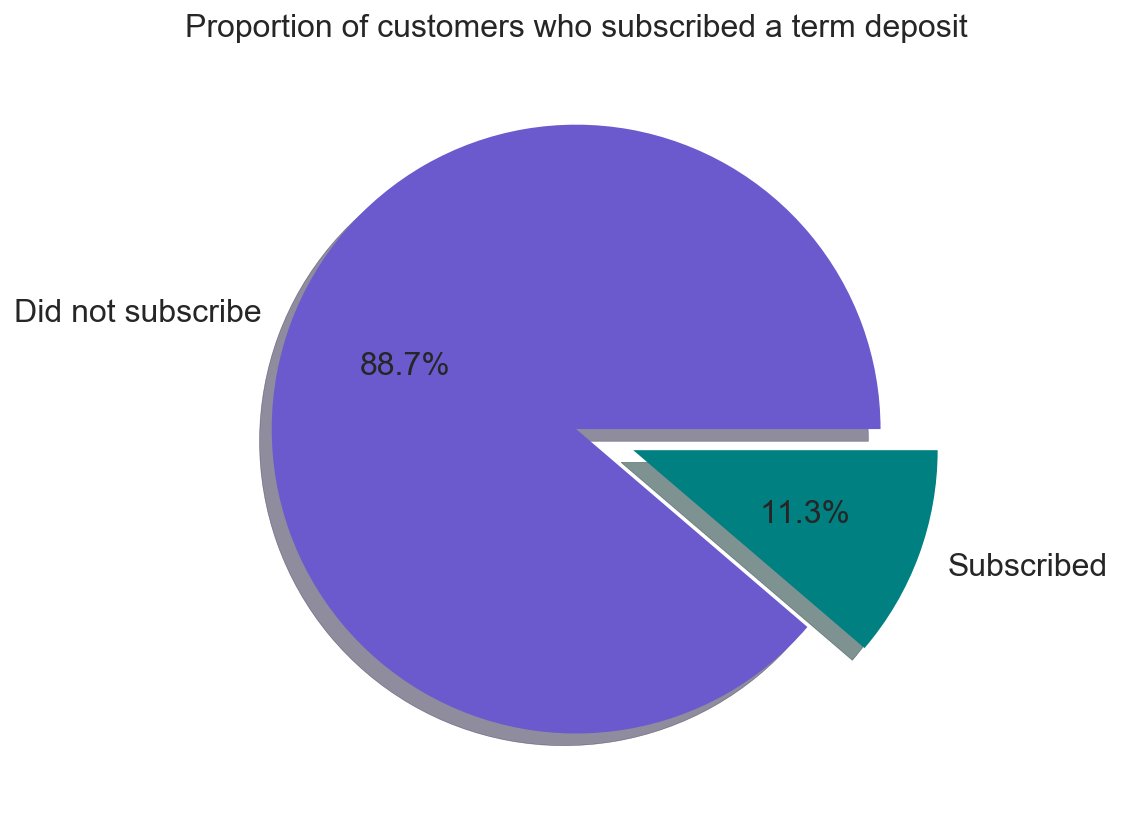

In [7]:
rate = df['y'].value_counts()

plt.style.use('seaborn') #set seaborn style for graphs in this analysis
rate.plot(kind='pie', figsize=(7,7), autopct='%.1f%%', fontsize=16, legend=False,
          colors=['slateblue', 'teal'], explode=(0,.2), shadow=True, 
          labels=['Did not subscribe', 'Subscribed'])
plt.title('Proportion of customers who subscribed a term deposit', fontdict={'fontsize':16})
plt.axis('off')
plt.show()

The main information to check is the proportion of customers appears who has accepted the bank's offer to those who have rejected it. The chart above shows that only 11.3% of the clients contacted by the bank were interested in subscribing a term deposit.

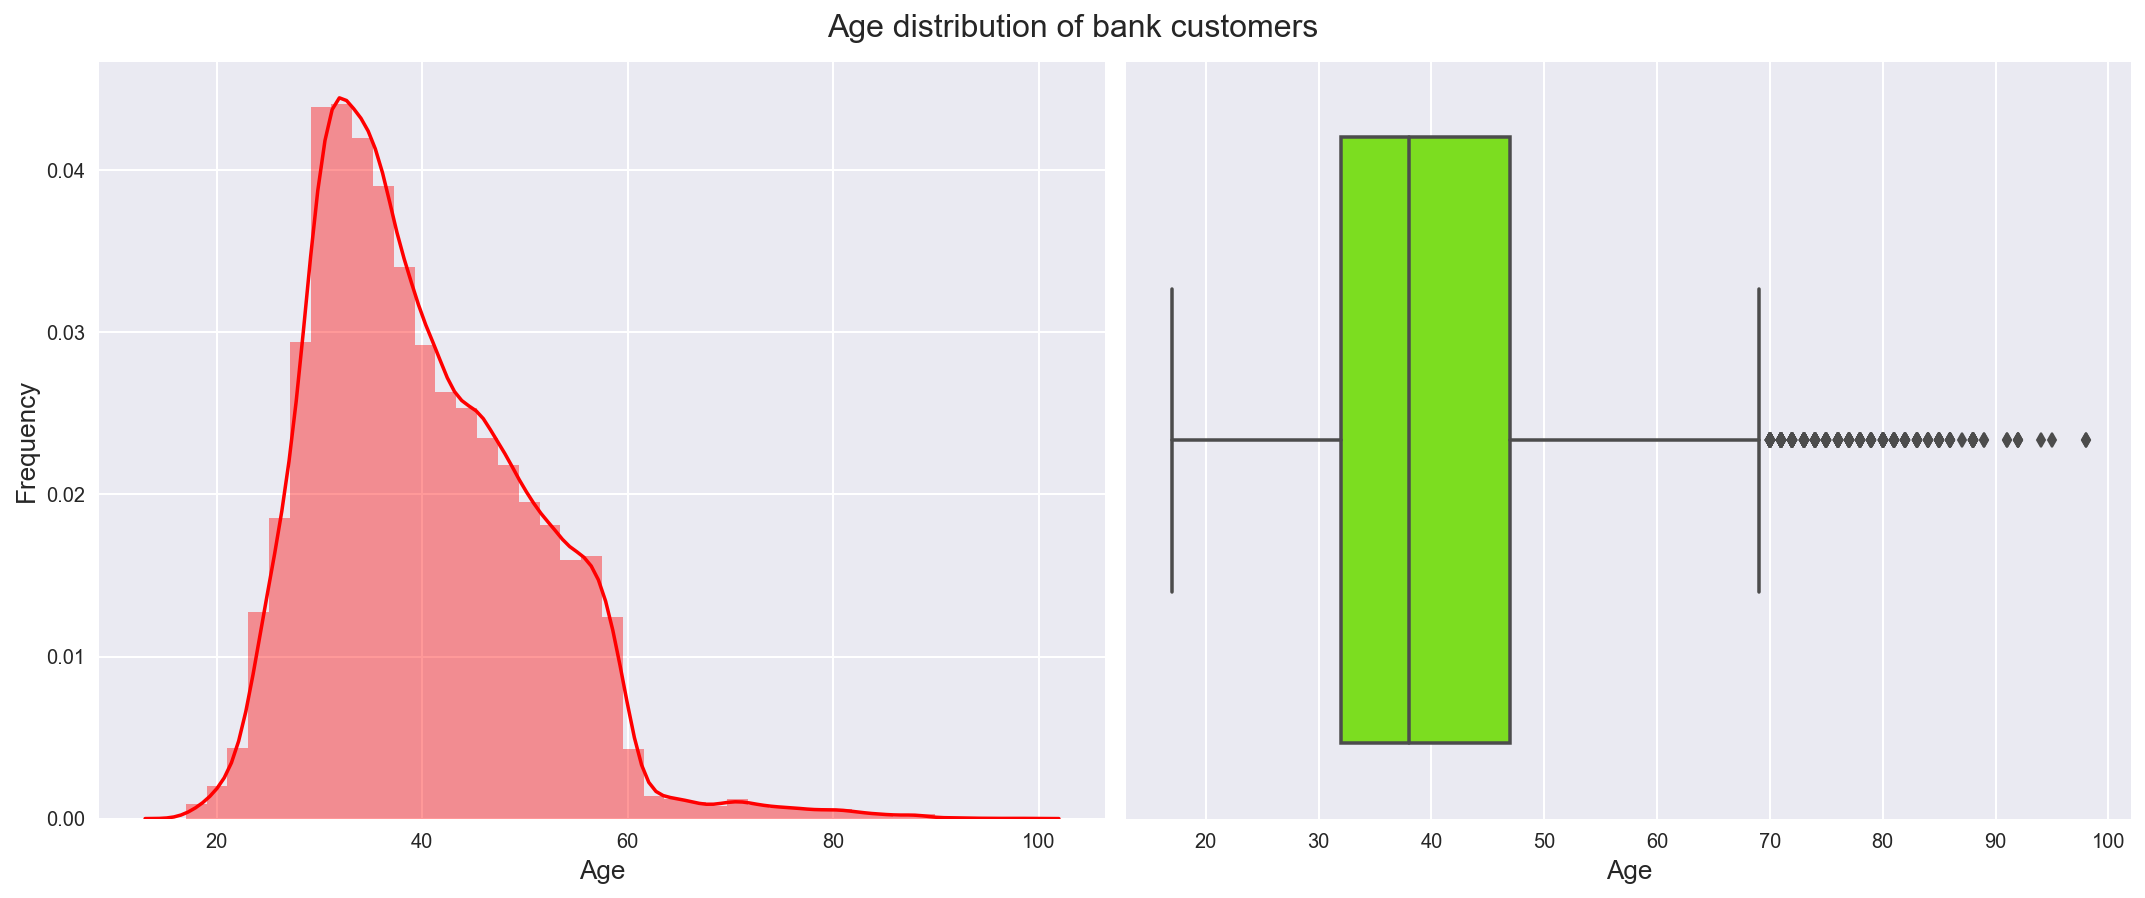

In [8]:
plt.figure(figsize=(15,6))
plt.suptitle('Age distribution of bank customers', y=1.03, fontsize=16) 
plt.subplot(121)
sns.distplot(df['age'], bins=40, color='red')
plt.xlabel('Age', fontdict={'fontsize':13})
plt.ylabel('Frequency', fontdict={'fontsize':13})

plt.subplot(122)
sns.boxplot(df['age'], orient='h', color='lawngreen')
plt.xlabel('Age', fontdict={'fontsize':13})
plt.tight_layout()
plt.show()

The above charts present the age distribution of bank customers. What is particularly noticeable is the large number of outliers in the case of a higher age - people 70+ are very rare compared to a large number of middle-aged people. The distribution is right skewed.

In [9]:
def display_count(plot):
    for p in plot.patches:
        plot.annotate(s = p.get_height(), 
                      xy = (p.get_x() + p.get_width() / 2, p.get_height()),
                      ha = 'center', 
                      va = 'center', 
                      xytext = (0, 8), 
                      textcoords = 'offset points',
                      color='black',
                      fontsize=12)

A supporting function will be defined that will display the calculated values above subsequent bar charts.

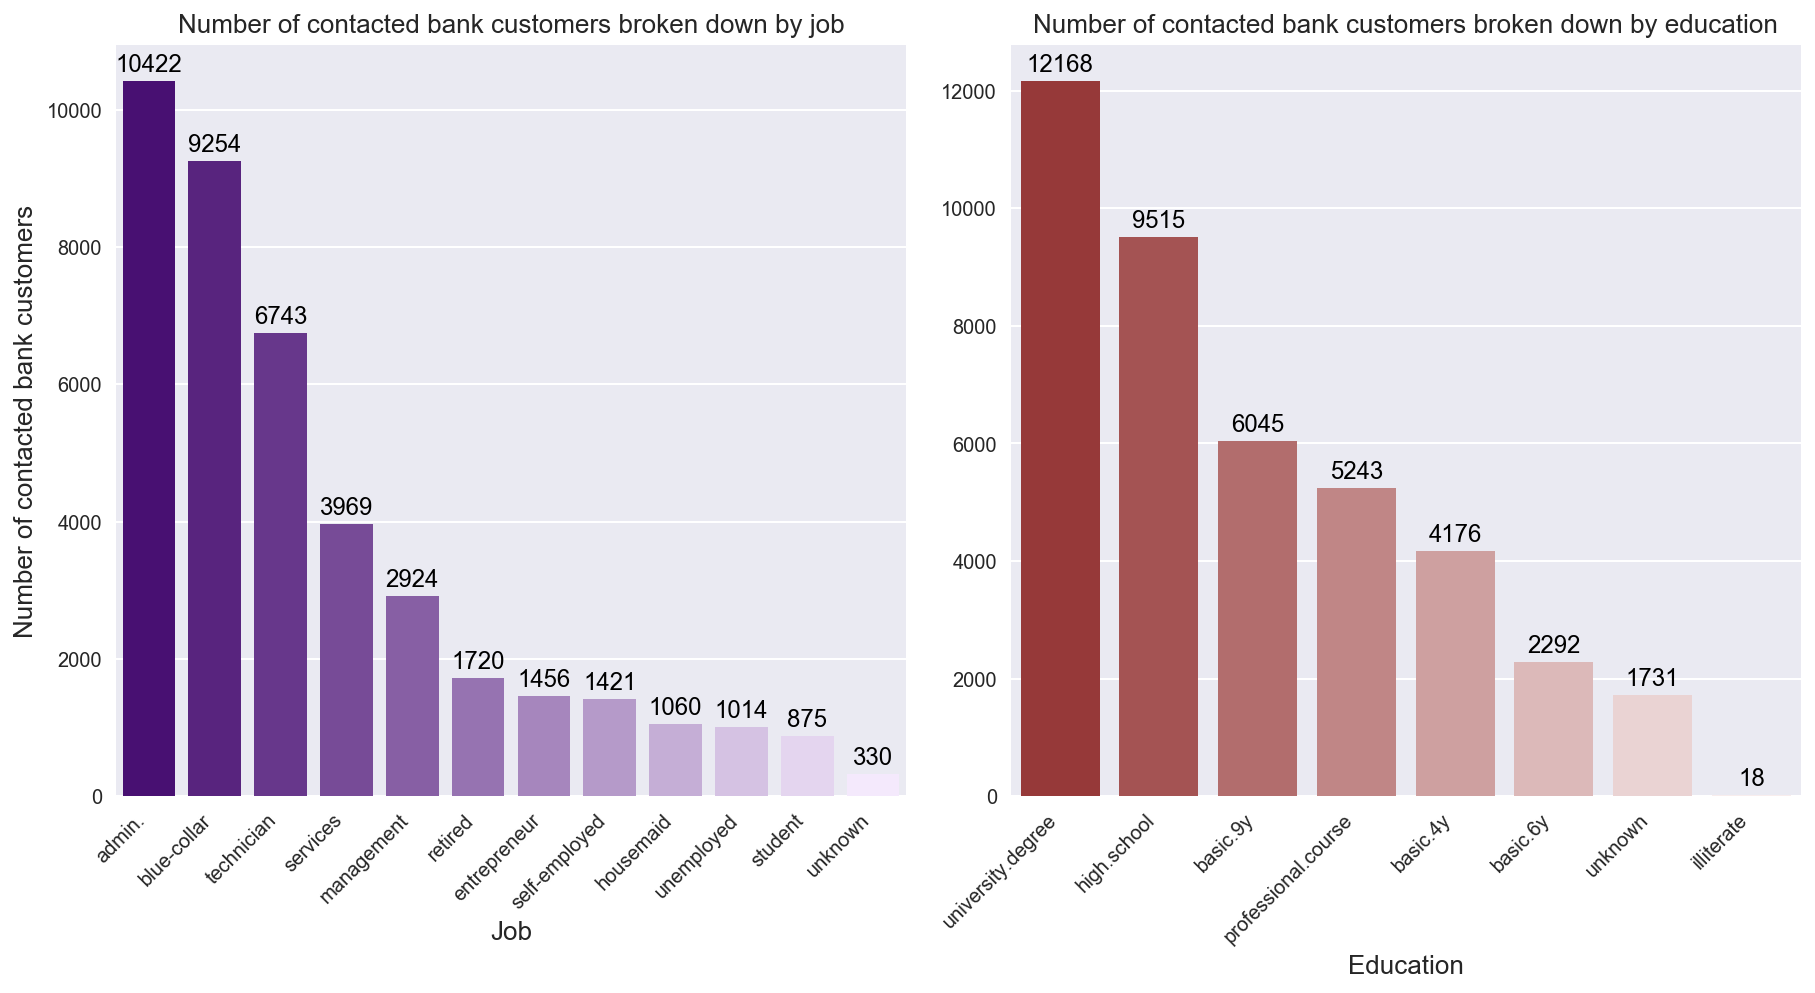

In [10]:
plt.figure(figsize=(13,7))
plt.subplot(121)
palette = sns.light_palette("indigo", reverse=True, n_colors=df['job'].nunique())
plot1 = sns.countplot(df['job'], palette=palette, order=df['job'].value_counts().index)
display_count(plot1)
plt.xlabel('Job', fontdict={'fontsize':13})
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of contacted bank customers', fontdict={'fontsize':13})
plt.title('Number of contacted bank customers broken down by job', fontdict={'fontsize':13})

plt.subplot(122)
palette = sns.light_palette("brown", reverse=True, n_colors=df['education'].nunique())
plot2 = sns.countplot(df['education'], palette=palette, order=df['education'].value_counts().index)
display_count(plot2)
plt.xlabel('Education', fontdict={'fontsize':13})
plt.xticks(rotation=45, ha='right')
plt.ylabel('')
plt.title('Number of contacted bank customers broken down by education', fontdict={'fontsize':13})

plt.tight_layout()
plt.show()

Most clients perform office work (over 10k), however manual work is also very popular (9.2k). Other activities are characterized by much lower popularity.

When it comes to formal education,  most people have university degree. Almost no one is illiterate. In the case of both distributions, unknown values constitute a fairly small proportion of customers.

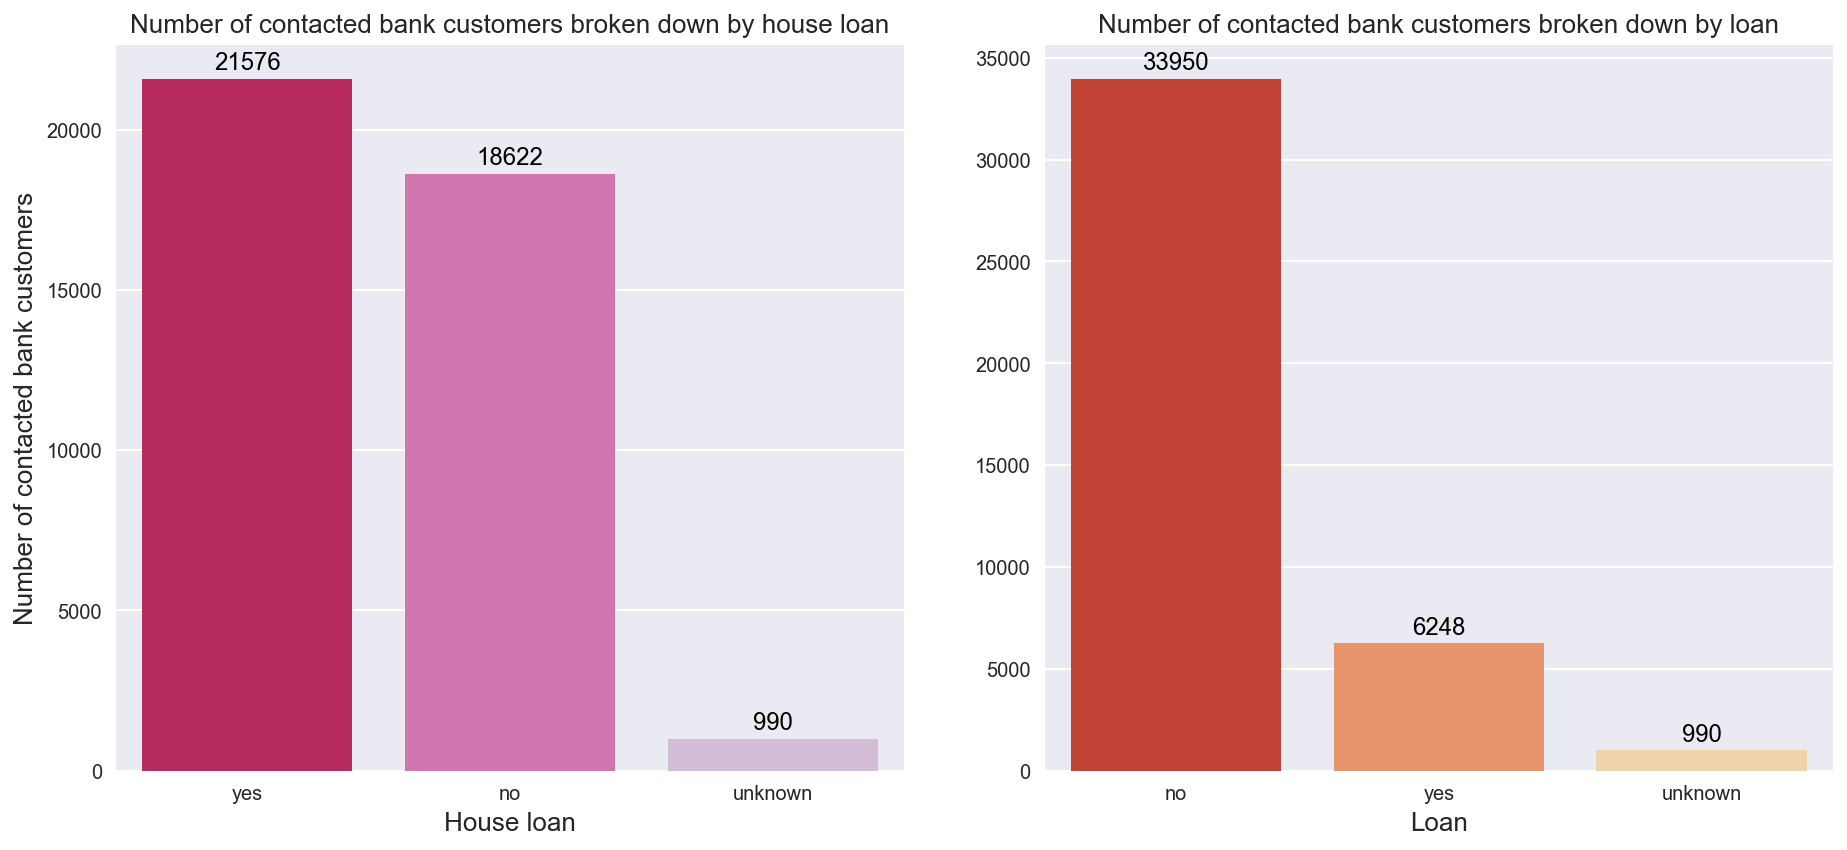

In [11]:
plt.figure(figsize=(13,6))
plt.subplot(121)
plot1 = sns.countplot(df['housing'], palette='PuRd_r', order=df['housing'].value_counts().index)
display_count(plot1)
plt.xlabel('House loan', fontdict={'fontsize':13})
plt.ylabel('Number of contacted bank customers', fontdict={'fontsize':13})
plt.title('Number of contacted bank customers broken down by house loan', fontdict={'fontsize':13})
plt.subplot(122)

plot2 = sns.countplot(df['loan'], palette='OrRd_r', order=df['loan'].value_counts().index)
display_count(plot2)
plt.xlabel('Loan', fontdict={'fontsize':13})
plt.ylabel('')
plt.title('Number of contacted bank customers broken down by loan', fontdict={'fontsize':13})
plt.tight_layout()
plt.show()

In the case of having a home loan, the distribution is much more even - the number of people having a home loan exceeds the number of people who do not have a home loan by only 3,000.
The case is quite different when it comes to ordinary loans - the vast majority do not have one.

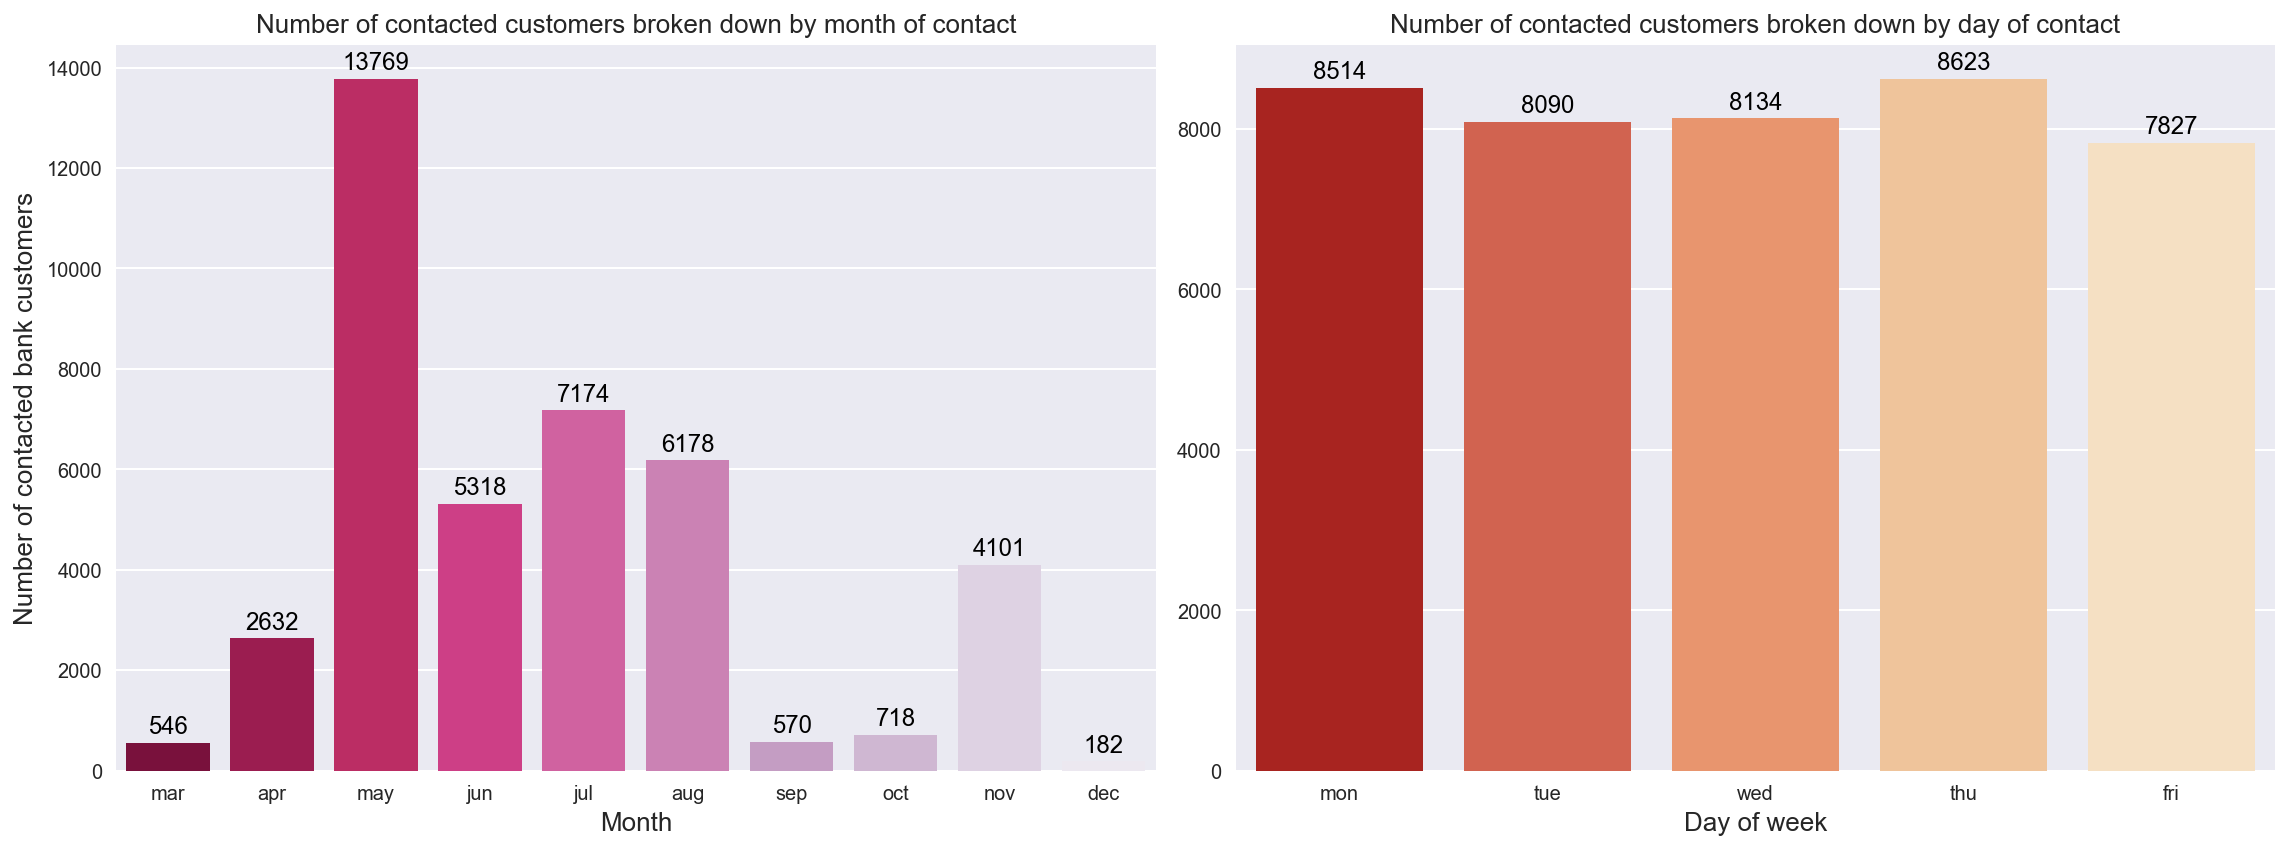

In [12]:
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

plt.figure(figsize=(16,6))
plt.subplot(121)

x = sns.countplot(df['month'], palette='PuRd_r', order=month_order)
display_count(x)
plt.xlabel('Month', fontdict={'fontsize':13})
plt.ylabel('Number of contacted bank customers', fontdict={'fontsize':13})
plt.title('Number of contacted customers broken down by month of contact', fontdict={'fontsize':13})
plt.subplot(122)

y = sns.countplot(df['day_of_week'], palette='OrRd_r', order=day_order)
display_count(y)
plt.xlabel('Day of week', fontdict={'fontsize':13})
plt.ylabel('')
plt.title('Number of contacted customers broken down by day of contact', fontdict={'fontsize':13})
plt.tight_layout()
plt.show()

The above charts provide information on the duration of the marketing campaign at the bank. The highest contact frequency occurred in the spring and summer. As for the division into days, employees work hard every working day of the week!

In [13]:
grouped_maritial = df.groupby(['marital', 'y'])['age'].count().unstack()
for index, row in grouped_maritial.iterrows():
    grouped_maritial.loc[index, 'False_prc'] = row[0] / (row[0] + row[1])
    grouped_maritial.loc[index, 'True_prc'] = row[1] / (row[0] + row[1])
grouped_maritial

y,0,1,False_prc,True_prc
marital,,,,
divorced,4136,476,0.896791,0.103209
married,22396,2532,0.898427,0.101573
single,9948,1620,0.859959,0.140041
unknown,68,12,0.850000,0.150000


Next, a chart will be presented where the number of clients is broken down by civil status. To additionally determine which part of them accepted the bank's offer, an additional table with appropriate calculations must be created.

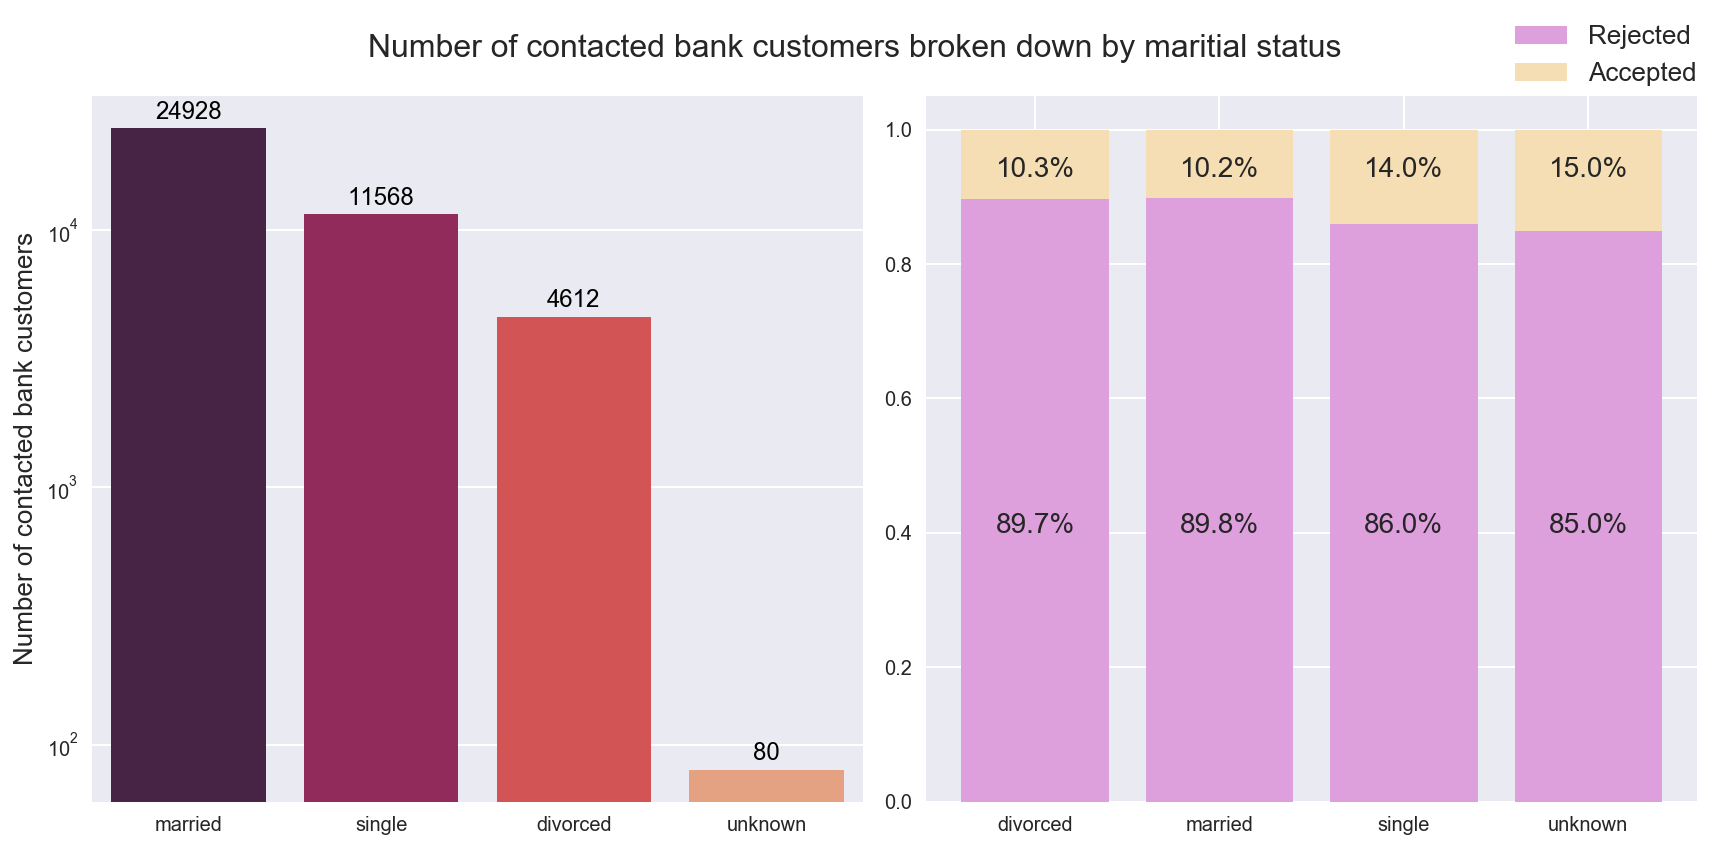

In [14]:
plt.figure(figsize=(12,6))
plt.suptitle('Number of contacted bank customers broken down by maritial status', y=.95,
             fontsize=16)

plt.subplot(121)
plot = sns.countplot(df['marital'], palette='rocket', 
        order=df['marital'].value_counts().index, log=True)
display_count(plot)
plt.xlabel('')
plt.ylabel('Number of contacted bank customers', fontdict={'fontsize':13})

plt.subplot(122)
bar1 = plt.bar(grouped_maritial.index, grouped_maritial['False_prc'], label='Rejected', 
               color='plum')
bar2 = plt.bar(grouped_maritial.index, grouped_maritial['True_prc'], color='wheat',
               bottom=grouped_maritial['False_prc'], label='Accepted')
for r1, r2 in zip(bar1, bar2):
    h1 = r1.get_height()
    h2 = r2.get_height()
    plt.text(r1.get_x()+r1.get_width()/2, 0.4, '{:.1%}'.format(h1), ha="center", fontsize=14)
    plt.text(r2.get_x()+r2.get_width()/2, 0.93,'{:.1%}'.format(h2), ha="center", fontsize=14) 
plt.legend(bbox_to_anchor=(.75,1,0,0), 
           loc='lower right',mode="expand", borderaxespad=0., prop={'size':13})

plt.tight_layout()
plt.show()

Most customers are married. What is more interesting, the proportion of clients who have accepted or rejected the bank's offer is almost identical for divorced and married customers, but singles are more likely to accept the offer.

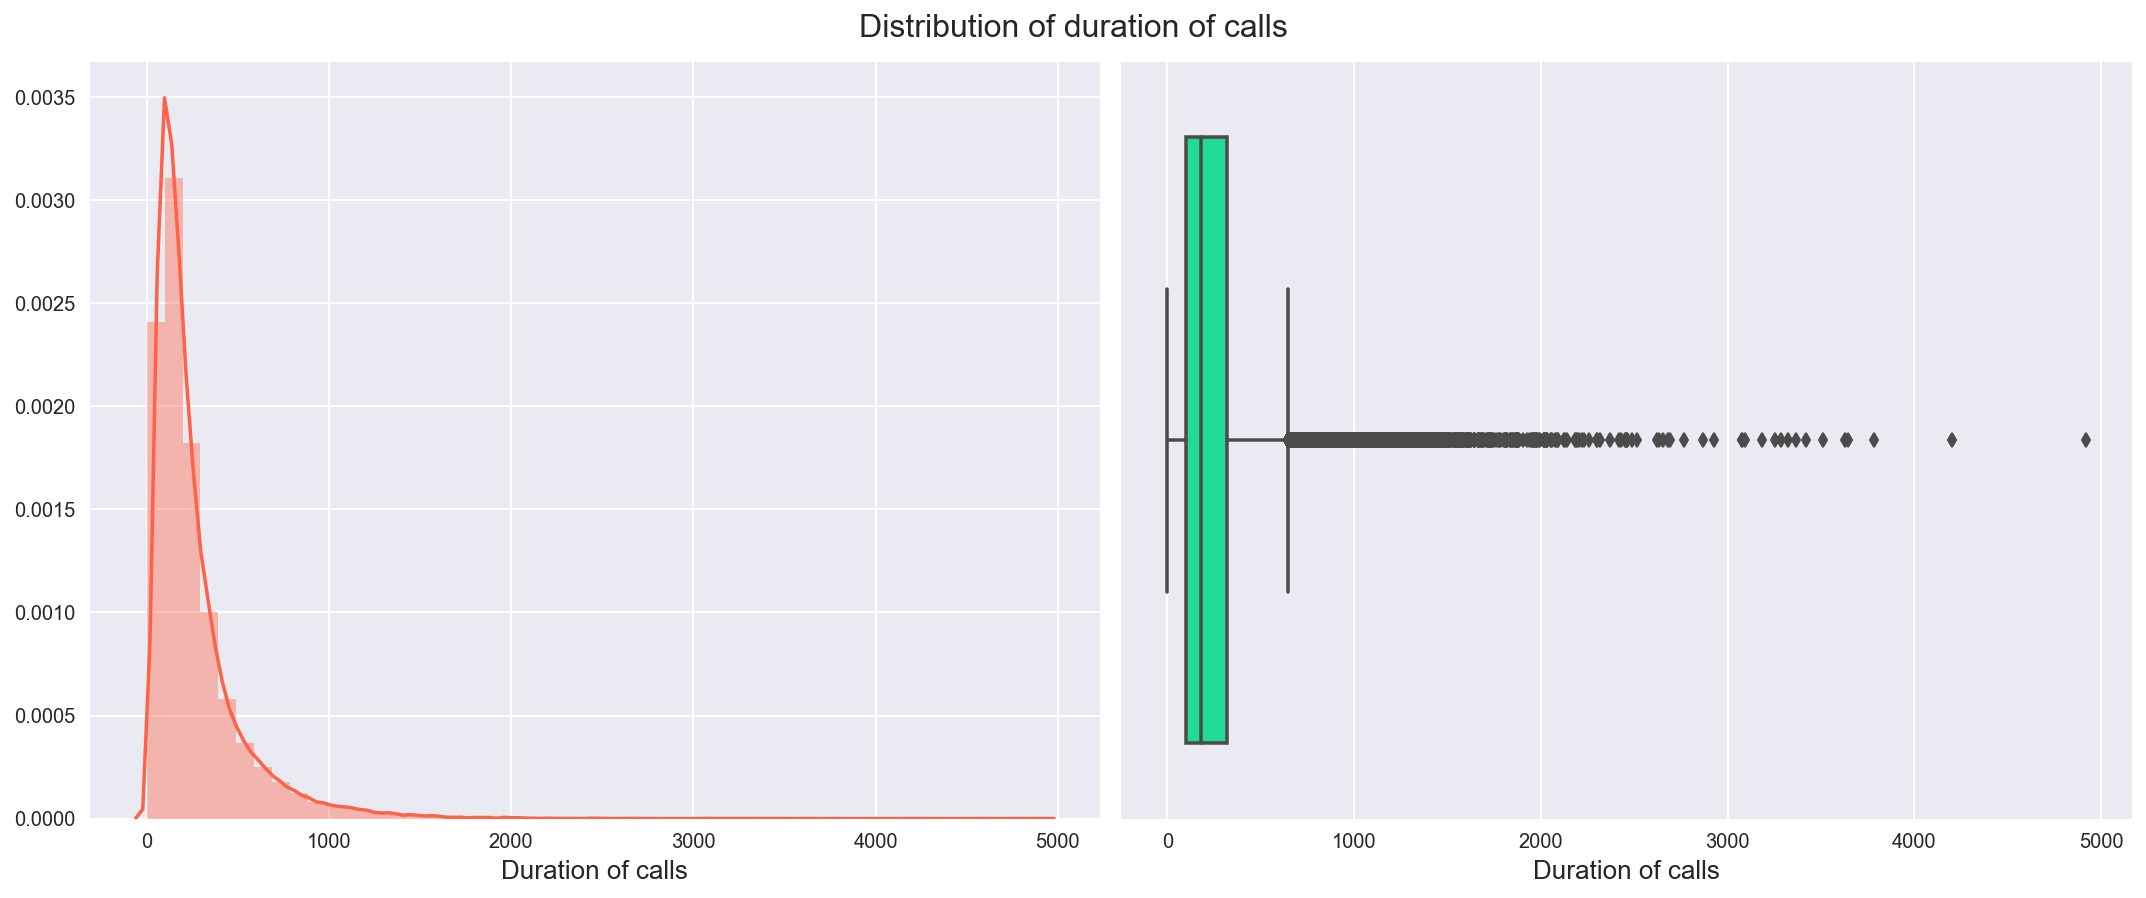

In [15]:
plt.figure(figsize=(15,6))
plt.suptitle('Distribution of duration of calls', y=1.03, fontsize=16) 
plt.subplot(121)
sns.distplot(df['duration'], color='tomato')
plt.xlabel('Duration of calls', fontdict={'fontsize':13})

plt.subplot(122)
sns.boxplot(df['duration'], orient='h', color='mediumspringgreen')
plt.ylabel('')
plt.xlabel('Duration of calls', fontdict={'fontsize':13})

plt.tight_layout()
plt.show()

An important factor affecting whether an offer has been accepted is the length of the telephone conversation between the bank and the customer. The distribution of call duration (in seconds) is extremely right-skewed. The average duration of a conversation is 4.5 minutes, but the presented data shows a very large number of extreme outliers that reach up to over 80 minutes.

Under normal circumstances,  outliers should probably be removed, because they may falsify results (including mean), but a very important point should be noted: The duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input **will not be included** in future analysis and models within this analysis. Discarding this feature will significantly deteriorate the quality of predictions, but without this feature potential models will more accurately reflect reality.

# Data preprocessing for machine learning

In [16]:
#discarding the abovementioned duration feature for more realistic predictions
df = df.drop('duration', axis=1)

One of the proposals for better preparation of data for analysis may be data grouping - for instance, the age of customers can be assigned to appropriate groups - in this way potential models have a greater opportunity for effective learning - for example, people of old age are gathered into a larger group, which is supposed to reflect their common characteristics, thanks to which the model has more time to learn them properly.

In [17]:
bins = [0, 29, 40, 50, 60, 100]
labels = ['young_adults', 'adults_30s', 'adults_40s', 'adults_50s', 'seniors']
age_binned = pd.cut(df['age'], bins=bins, labels=labels)
age_binned.name = 'age_binned'
df = pd.concat([df, age_binned], axis=1)

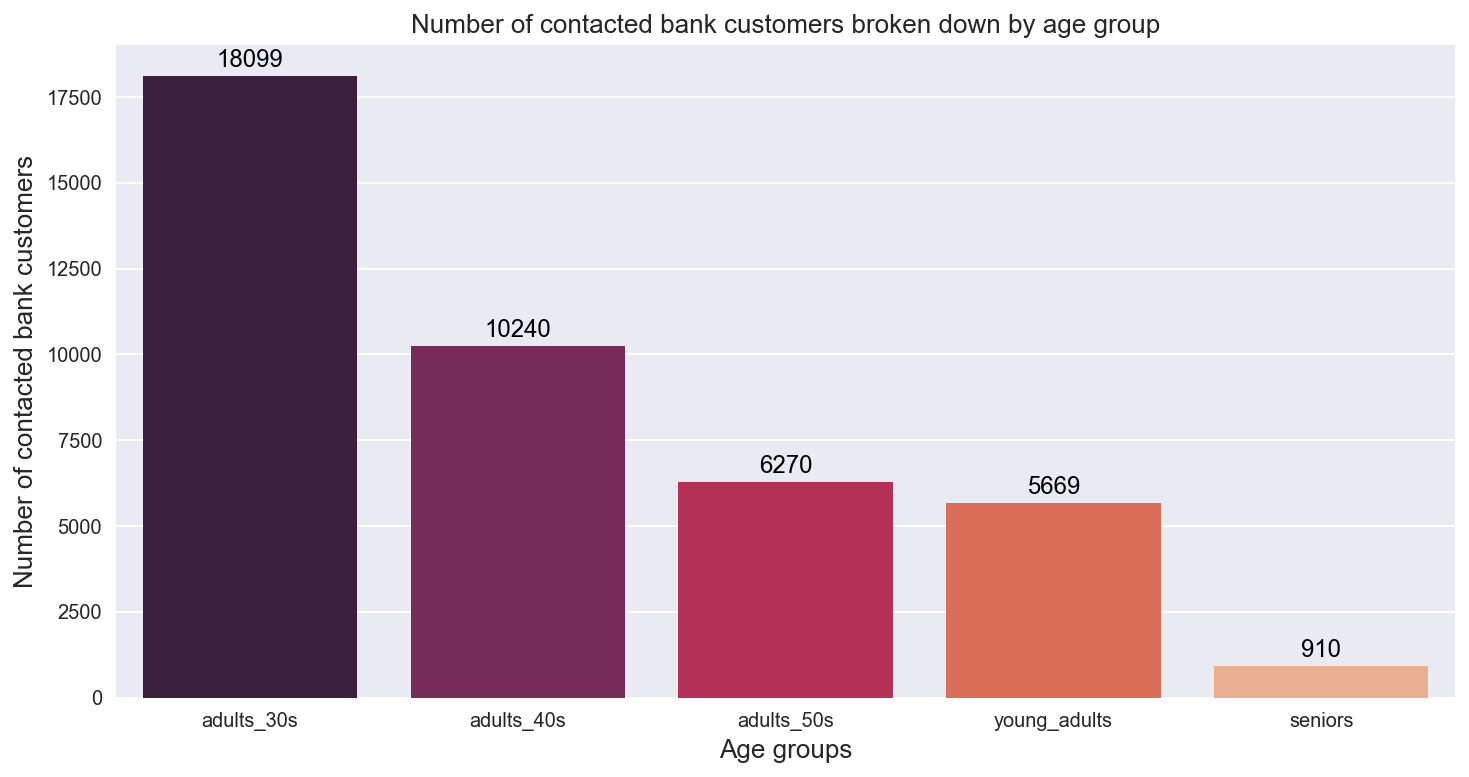

In [18]:
plt.figure(figsize=(12,6))
plot = sns.countplot(df['age_binned'], palette='rocket', 
        order=df['age_binned'].value_counts().index)
display_count(plot)
plt.xlabel('Age groups', fontdict={'fontsize':13})
plt.ylabel('Number of contacted bank customers', fontdict={'fontsize':13})
plt.title('Number of contacted bank customers broken down by age group', 
          fontdict={'fontsize':13})
plt.show()

After gathering the age of participants in the appropriate groups, it can be seen that the majority are middle-aged people. Especially seniors, who are the least among the group of customers together, may allow the model to work better.

Months can be considered to be in a similar situation - especially the autumn and winter months are the least frequent in the presented data.

In [19]:
month_dic = {'may':5, 'jun':6, 'jul':7, 'aug':8, 'oct':10, 
             'nov':11, 'dec':12, 'mar':3, 'apr':4,'sep':9}
df['month'] = df['month'].map(month_dic)

bins = [0, 5, 8, 12]
labels = ['spring', 'summer', 'autumn']
month_binned = pd.cut(df['month'], bins=bins, labels=labels)
month_binned.name = 'month_binned'
df = pd.concat([df, month_binned], axis=1)

In [20]:
df.iloc[:,-2:].head()

,age_binned,month_binned
0,adults_50s,spring
1,adults_50s,spring
2,adults_30s,spring
3,adults_30s,spring
4,adults_50s,spring


In [21]:
day_dic = {'mon':1, 'tue':2, 'wed':3, 'thu':4, 'fri':5}
df['day_of_week'] = df['day_of_week'].map(day_dic)

To prepare the data, the days of the week are changed from category to numbers. One could think about adding sine / cosine transformation so that Monday (0) would be perceived closed to Friday (4). In this case, these days are separated by the weekend, so this transformation will not be applied.

In [22]:
df['pdays'] = df['pdays'].apply(lambda x: 0 if x==999 else 1)
df.rename({'pdays':'previous_contact', 'previous':'no_prv_contacts'}, axis=1, inplace=True)

The 'pday' category contains very extreme values - from small (1-5) to 999, where the latter symbolizes the lack of contact. This does not seem to have a positive impact on the performance of potential models, so this feature is changed to binary representation of whether previous contact with the client existed.

Another consideration to consider is choosing the right data for your model. Above, additional variables have been created to symbolize the groups of clients by age and time of year in which contact occurred (age_binned and month_binned. The presence of 'unknown' value in some of the features is also very important. Although there are not very many of them in the scale of the whole model, they can cause noise that will make prediction difficult. You can consider deleting all lines where 'unknown' occurs at least once - it will decrease the number of clients by a few thousands but may improve its quality.

The following are 8 different sets of data that symbolize different attribute selection options. Based on logistic regression (as its calculation takes a relatively short time) the set of data having the highest predictive value will be assessed.

In [23]:
#original sets
df11 = df.drop(['age_binned', 'month_binned'], axis=1)  #set No. 1
df12 = df.drop(['age', 'month_binned'], axis=1)         #set No. 2
df13 = df.drop(['age_binned', 'month'], axis=1)         #set No. 3
df14 = df.drop(['age', 'month'], axis=1)                #set No. 4

#sets with 'unknown' values dropped
#set No. 5
df21 = df.replace('unknown', np.nan).dropna(how='any').drop(['age_binned', 'month_binned'], axis=1)
#set No. 6
df22 = df.replace('unknown', np.nan).dropna(how='any').drop(['age', 'month_binned'], axis=1)
#set No. 7
df23 = df.replace('unknown', np.nan).dropna(how='any').drop(['age_binned', 'month'], axis=1)
#set No. 8
df24 = df.replace('unknown', np.nan).dropna(how='any').drop(['age', 'month'], axis=1)

list_df = [df11, df12, df13, df14, df21, df22, df23, df24]

In [24]:
#creating dummy lists for diffrent scenarios
dummies1 = ['job', 'marital', 'education', 'default', 'housing', 
           'loan', 'contact', 'previous_contact', 'poutcome']
dummies2 = ['job', 'marital', 'education', 'default', 'housing', 
           'loan', 'contact', 'previous_contact', 'poutcome', 'age_binned']
dummies3 = ['job', 'marital', 'education', 'default', 'housing', 
           'loan', 'contact', 'previous_contact', 'poutcome', 'month_binned']
dummies4 = ['job', 'marital', 'education', 'default', 'housing', 
           'loan', 'contact', 'previous_contact', 'poutcome', 'age_binned', 'month_binned']
list_dummies = [dummies1, dummies2, dummies3, dummies4] * 2

In [25]:
scores = pd.DataFrame()
c = 1
for dataframe, dummies in zip(list_df, list_dummies):
    
    y = dataframe['y'].values
    dataframe = dataframe.drop(['y'], axis=1)
    X = pd.get_dummies(dataframe, columns=dummies, prefix=dummies, drop_first=True)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    
    log_reg = LogisticRegression()
    log_reg.fit(X_train, y_train)
    
    scores.loc['Accuracy', 'Set {}'.format(c)] = cross_val_score(
        log_reg, X_test, y_test, cv=5, n_jobs=-1, scoring='accuracy').mean()
    scores.loc['F1', 'Set {}'.format(c)] = cross_val_score(
        log_reg, X_test, y_test, cv=5, n_jobs=-1, scoring='f1').mean()
    scores.loc['Precision', 'Set {}'.format(c)] = cross_val_score(
        log_reg, X_test, y_test, cv=5, n_jobs=-1, scoring='precision').mean()
    scores.loc['Recall', 'Set {}'.format(c)] = cross_val_score(
        log_reg, X_test, y_test, cv=5, n_jobs=-1, scoring='recall').mean()
    scores.loc['ROC_AUC', 'Set {}'.format(c)] = cross_val_score(
        log_reg, X_test, y_test, cv=5, n_jobs=-1, scoring='roc_auc').mean()
    c += 1

scores

,Set 1,Set 2,Set 3,Set 4,Set 5,Set 6,Set 7,Set 8
Accuracy,0.899249,0.899613,0.899370,0.899977,0.884224,0.884224,0.884060,0.882584
F1,0.359864,0.365223,0.356425,0.361576,0.359082,0.362721,0.358723,0.353515
Precision,0.650113,0.650515,0.655135,0.659888,0.641435,0.638479,0.639100,0.622123
Recall,0.250000,0.255319,0.245745,0.250000,0.249709,0.253483,0.249701,0.247178
ROC_AUC,0.781659,0.781155,0.784427,0.783702,0.794542,0.794006,0.795360,0.794955


In [26]:
scores.idxmax(axis=1)

Accuracy     Set 4
F1           Set 2
Precision    Set 4
Recall       Set 2
ROC_AUC      Set 7
dtype: object

Considering the above, it should be noted that the best set depends on what type of scoring will be adopted. However, the results do not differ significantly, which suggests that the problem of choosing the right attributes was not that important as initially thought. 

In this case, the analysis will include set No. 7 (with observations without the  'unknown' values, months grouped in seasons, and with the original age values, i.e. continuous numeration) - this set has the highest value of the roc_auc scoring, which is very significant in case of binary classification of output data.

In [27]:
df = df23.copy()
y = df['y'].values
df = df.drop(['y'], axis=1)

In [28]:
dummies = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
           'contact', 'poutcome', 'month_binned']
X = pd.get_dummies(df, columns=dummies, prefix=dummies, drop_first=True)
X.head()

,age,day_of_week,campaign,previous_contact,no_prv_contacts,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success,month_binned_summer,month_binned_autumn
0,56,1,1,0,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,1,1,0,0,0
2,37,1,1,0,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,1,0,1,1,0,0,0
3,40,1,1,0,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,0,1,1,0,0,0
4,56,1,1,0,0,1.1,93.994,-36.4,4.857,5191.0,...,0,0,0,0,1,1,1,0,0,0
6,59,1,1,0,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,0,1,1,0,0,0


In order to prepare the dataset, non-numeric values have been transformed into 'dummy variables', i.e. in such a way that they are determined in a binary way. This process also increased the number of attributes to 36.

In the next step, the dataset prepared in this way is divided into a part that will be used to train models and a part that will be used to test them. In addition, independent variables will be scaled, so the values of each feature in the data have zero-mean and unit-variance.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=123)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Logistic regression

First, a logistic regression model will be prepared. At first step, the best parameters of the model are searched with GridSearchCV, which will allow to obtain the highest result of roc_auc.

In [30]:
log_classifier = LogisticRegression()
grid_params_log =  {'C' : np.logspace(-4, 4, 9), 
                 'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid_search = GridSearchCV(estimator=log_classifier, param_grid=grid_params_log,
                             scoring='roc_auc', cv=3, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

In [31]:
print('Best score: {}\nBest parameters: {}'.
      format(grid_search.best_score_, grid_search.best_params_))

Best score: 0.7875794378851902
Best parameters: {'C': 1000.0, 'solver': 'lbfgs'}


With the best parameters specified, the final model is created. What is more, initial values are predicted:
- y_pred - values predicted by the model based on test data;
- y_proba - probability values of qualifying the variable into a given category.

In [32]:
log_classifier = LogisticRegression(C=1000, solver='lbfgs', max_iter=500)
log_classifier.fit(X_train, y_train)
y_pred_log = log_classifier.predict(X_test)
y_proba_log = log_classifier.predict_proba(X_test)

In [33]:
log_reg_score = cross_val_score(log_classifier, X_train, 
                                y_train, cv=10, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'.
      format(log_reg_score.mean(),log_reg_score.std()))

models = pd.DataFrame()
models.loc['logistic_regression','accuracy'] = accuracy_score(y_test, y_pred_log)
models.loc['logistic_regression','roc_auc'] = log_reg_score.mean()
models.loc['logistic_regression','f1'] = f1_score(y_test, y_pred_log)
models.loc['logistic_regression','precision'] = precision_score(y_test, y_pred_log)
models.loc['logistic_regression','recall'] = recall_score(y_test, y_pred_log)

Mean roc_auc score: 78.885%
Standard deviation: 1.301%


The final stage for this model is to prepare the results for future comparisons with other algorithms. The cross_val_score() function calculates the results several times and their average is stored in a newly created table with the results of the other models for future easy comparison.

# k-nearest neighbors

For subsequent models, the process of selecting variables and assigning scores to the table will be the same as shown above.

In [34]:
kn_classifier = KNeighborsClassifier()
grid_params_kn =  {'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_search = GridSearchCV(estimator=kn_classifier, param_grid=grid_params_kn,
                             scoring='roc_auc', cv=3, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

In [35]:
print('Best score: {}\nBest parameters: {}'.
      format(grid_search.best_score_, grid_search.best_params_))

Best score: 0.712607937694855
Best parameters: {'algorithm': 'ball_tree'}


In [36]:
kn_classifier = KNeighborsClassifier(algorithm='ball_tree')
kn_classifier.fit(X_train, y_train)
y_pred_kn = kn_classifier.predict(X_test)
y_proba_kn = kn_classifier.predict_proba(X_test)

In [37]:
kn_score = cross_val_score(kn_classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'
      .format(kn_score.mean(),kn_score.std()))

models.loc['kneighbors','accuracy'] = accuracy_score(y_test, y_pred_kn)
models.loc['kneighbors','roc_auc'] = kn_score.mean()
models.loc['kneighbors','f1'] = f1_score(y_test, y_pred_kn)
models.loc['kneighbors','precision'] = precision_score(y_test, y_pred_kn)
models.loc['kneighbors','recall'] = recall_score(y_test, y_pred_kn)

Mean roc_auc score: 71.664%
Standard deviation: 1.380%


# Support-vector machine

In [38]:
#For this model, the GridSearchCV function was not used to find the best parameters due 
#to the limitations of the computer power on which this analysis was prepared.
svc_classifier = SVC(kernel='rbf')
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
y_score_svc = svc_classifier.decision_function(X_test)

In [39]:
svc_score = cross_val_score(svc_classifier, X_train, y_train, cv=3, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'
      .format(svc_score.mean(),svc_score.std()))

models.loc['SVC','accuracy'] = accuracy_score(y_test, y_pred_svc)
models.loc['SVC','roc_auc'] = svc_score.mean()
models.loc['SVC','f1'] = f1_score(y_test, y_pred_svc)
models.loc['SVC','precision'] = precision_score(y_test, y_pred_svc)
models.loc['SVC','recall'] = recall_score(y_test, y_pred_svc)

Mean roc_auc score: 69.267%
Standard deviation: 0.992%


# Naive Bayes 

In [40]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
y_score_nb = svc_classifier.decision_function(X_test)

In [41]:
nb_score = cross_val_score(nb_classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'
      .format(nb_score.mean(),nb_score.std()))

models.loc['naive_bayess','accuracy'] = accuracy_score(y_test, y_pred_nb)
models.loc['naive_bayess','roc_auc'] = nb_score.mean()
models.loc['naive_bayess','f1'] = f1_score(y_test, y_pred_nb)
models.loc['naive_bayess','precision'] = precision_score(y_test, y_pred_nb, zero_division=True)
models.loc['naive_bayess','recall'] = recall_score(y_test, y_pred_nb)

Mean roc_auc score: 75.940%
Standard deviation: 0.751%


# Decision tree and random forest

The 'decision tree' and 'random forest' models require a different approach to data preparation. In the case of previous models, categorical values were broken down into 'dummy variables' - but in these models, text values, as in other cases, should be converted into numerical values, but they are not broken down into individual additional categories (so-called dummy variables).

In [42]:
df_cat = df.copy()
for dummy in dummies:
    le = LabelEncoder()
    df_cat[dummy] = le.fit_transform(df[dummy])
df_cat.head()

,age,job,marital,education,default,housing,loan,contact,day_of_week,campaign,previous_contact,no_prv_contacts,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,month_binned
0,56,3,1,0,0,0,0,1,1,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1
2,37,7,1,3,0,1,0,1,1,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1
3,40,0,1,1,0,0,0,1,1,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1
4,56,7,1,3,0,0,1,1,1,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1
6,59,0,1,5,0,0,0,1,1,1,0,0,1,1.1,93.994,-36.4,4.857,5191.0,1


In [43]:
X_train_cat, X_test_cat = train_test_split(df_cat.values, test_size=.2, random_state=123)

Decision tree

In [44]:
tree_classifier = DecisionTreeClassifier()
grid_params_tree =  {'criterion' : ['gini', 'entropy'],
                     'splitter' : ['best', 'random']}
grid_search = GridSearchCV(estimator=tree_classifier, param_grid=grid_params_tree,
                             scoring='roc_auc', cv=3, n_jobs=-1)
grid_search = grid_search.fit(X_train_cat, y_train)

In [45]:
print('Best score: {}\nBest parameters: {}'.
      format(grid_search.best_score_, grid_search.best_params_))

Best score: 0.6285775727100763
Best parameters: {'criterion': 'entropy', 'splitter': 'best'}


In [46]:
tree_classifier = DecisionTreeClassifier(criterion='entropy', splitter='best')
tree_classifier.fit(X_train_cat, y_train)
y_pred_tree = tree_classifier.predict(X_test_cat)
y_proba_tree = tree_classifier.predict_proba(X_test_cat)

In [47]:
tree_score = cross_val_score(tree_classifier, X_train_cat, 
                             y_train, cv=10, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'
      .format(tree_score.mean(),tree_score.std()))

models.loc['decision_tree','accuracy'] = accuracy_score(y_test, y_pred_tree)
models.loc['decision_tree','roc_auc'] = tree_score.mean()
models.loc['decision_tree','f1'] = f1_score(y_test, y_pred_tree)
models.loc['decision_tree','precision'] = precision_score(y_test, y_pred_tree)
models.loc['decision_tree','recall'] = recall_score(y_test, y_pred_tree)

Mean roc_auc score: 62.984%
Standard deviation: 1.145%


Random forest

In [48]:
rf_classifier = RandomForestClassifier()
grid_params_rf = {'n_estimators' : np.arange(40,160,20),
                  'criterion' : ['gini', 'entropy']}
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=grid_params_rf,
                             scoring='roc_auc', cv=3, n_jobs=-1)
grid_search = grid_search.fit(X_train_cat, y_train)

In [49]:
print('Best score: {}\nBest parameters: {}'.
      format(grid_search.best_score_, grid_search.best_params_))

Best score: 0.7819461024594543
Best parameters: {'criterion': 'gini', 'n_estimators': 140}


In [50]:
rf_classifier = RandomForestClassifier(n_estimators=120, criterion='entropy')
rf_classifier.fit(X_train_cat, y_train)
y_pred_rf = rf_classifier.predict(X_test_cat)
y_proba_rf = rf_classifier.predict_proba(X_test_cat)

In [51]:
rf_score = cross_val_score(rf_classifier, X_train_cat, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'
      .format(rf_score.mean(),rf_score.std()))

models.loc['random_forest','accuracy'] = accuracy_score(y_test, y_pred_rf)
models.loc['random_forest','roc_auc'] = rf_score.mean()
models.loc['random_forest','f1'] = f1_score(y_test, y_pred_rf)
models.loc['random_forest','precision'] = precision_score(y_test, y_pred_rf)
models.loc['random_forest','recall'] = recall_score(y_test, y_pred_rf)

Mean roc_auc score: 78.231%
Standard deviation: 0.966%


# XGBoost

In [52]:
xgb_classifier = XGBClassifier(objective='binary:logistic')
grid_params_xgb =  {'n_estimators': np.arange(40, 160, 40),
                     'max_depth': np.arange(2, 10, 2)}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=grid_params_xgb,
                             scoring='roc_auc', cv=3, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

In [53]:
print('Best score: {}\nBest parameters: {}'.
      format(grid_search.best_score_, grid_search.best_params_))

Best score: 0.8077933098910813
Best parameters: {'max_depth': 2, 'n_estimators': 120}


In [54]:
xgb_classifier = XGBClassifier(objective='binary:logistic', learning_rate=0.01,
                              n_estimators=120, max_depth=2)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
y_proba_xgb = xgb_classifier.predict_proba(X_test)

In [55]:
xgb_score = cross_val_score(xgb_classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'
      .format(xgb_score.mean(),xgb_score.std()))

models.loc['XGBoost','accuracy'] = accuracy_score(y_test, y_pred_xgb)
models.loc['XGBoost','roc_auc'] = xgb_score.mean()
models.loc['XGBoost','f1'] = f1_score(y_test, y_pred_xgb)
models.loc['XGBoost','precision'] = precision_score(y_test, y_pred_xgb)
models.loc['XGBoost','recall'] = recall_score(y_test, y_pred_xgb)

Mean roc_auc score: 77.508%
Standard deviation: 1.005%


# Gradient Boost

In [56]:
gbc_classifier = GradientBoostingClassifier(learning_rate=0.01)
grid_params_gbc =  {'n_estimators': np.arange(40, 160, 40),
                    'max_depth': np.arange(2, 10, 2)}
grid_search = GridSearchCV(estimator=gbc_classifier, param_grid=grid_params_gbc,
                             scoring='roc_auc', cv=3, n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)

In [57]:
print('Best score: {}\nBest parameters: {}'.
      format(grid_search.best_score_, grid_search.best_params_))

Best score: 0.8052037550552633
Best parameters: {'max_depth': 6, 'n_estimators': 120}


In [58]:
gbc_classifier = GradientBoostingClassifier(learning_rate=0.01, n_estimators=120, max_depth=6)
gbc_classifier.fit(X_train, y_train)
y_pred_gbc = gbc_classifier.predict(X_test)
y_proba_gbc = gbc_classifier.predict_proba(X_test)

In [59]:
gbc_score = cross_val_score(gbc_classifier, X_train, y_train, cv=10, n_jobs=-1, scoring='roc_auc')
print('Mean roc_auc score: {:.3%}\nStandard deviation: {:.3%}'
      .format(gbc_score.mean(),gbc_score.std()))

models.loc['gradient_boost','accuracy'] = accuracy_score(y_test, y_pred_gbc)
models.loc['gradient_boost','roc_auc'] = gbc_score.mean()
models.loc['gradient_boost','f1'] = f1_score(y_test, y_pred_gbc)
models.loc['gradient_boost','precision'] = precision_score(y_test, y_pred_gbc)
models.loc['gradient_boost','recall'] = recall_score(y_test, y_pred_gbc)

Mean roc_auc score: 80.535%
Standard deviation: 1.060%


# Evaluation and selection of model

In [60]:
models.sort_values('accuracy', ascending=False, inplace=True)
models

,accuracy,roc_auc,f1,precision,recall
logistic_regression,0.886192,0.788851,0.332692,0.700405,0.218159
XGBoost,0.883240,0.775076,0.283702,0.701493,0.177806
SVC,0.882420,0.692670,0.290801,0.674312,0.185372
gradient_boost,0.881601,0.805352,0.252588,0.705202,0.153846
random_forest,0.877993,0.782309,0.390164,0.557377,0.300126
kneighbors,0.872253,0.716640,0.338148,0.518229,0.250946
naive_bayess,0.869957,0.759401,0.000000,1.000000,0.000000
decision_tree,0.831092,0.629843,0.351385,0.350943,0.351828


After pre-testing all selected models, it is necessary to choose the one that has the best prediction capabilities. By evaluating models in terms of simple accuracy score, they all have relatively similar, high results: from 0.83 to 0.886.

In [61]:
zero_score = accuracy_score(y_test, np.zeros(y_test.shape))

print("Accuracy score assuming that the model classifies all customers as \
those who will not agree to accept the bank's offer: {:.3%}".format(zero_score))

Accuracy score assuming that the model classifies all customers as those who will not agree to accept the bank's offer: 86.996%


It should be noted that although the results appear to be exceptionally good,  the dependent values are not evenly distributed! In this case the accuracy score can be significantly overstated or underestimated.

In the event that a given model decided to assign the value 0 to the analysed data each and every time, the accuracy score would be 86.996%. This means that the model should perform better than this base result.

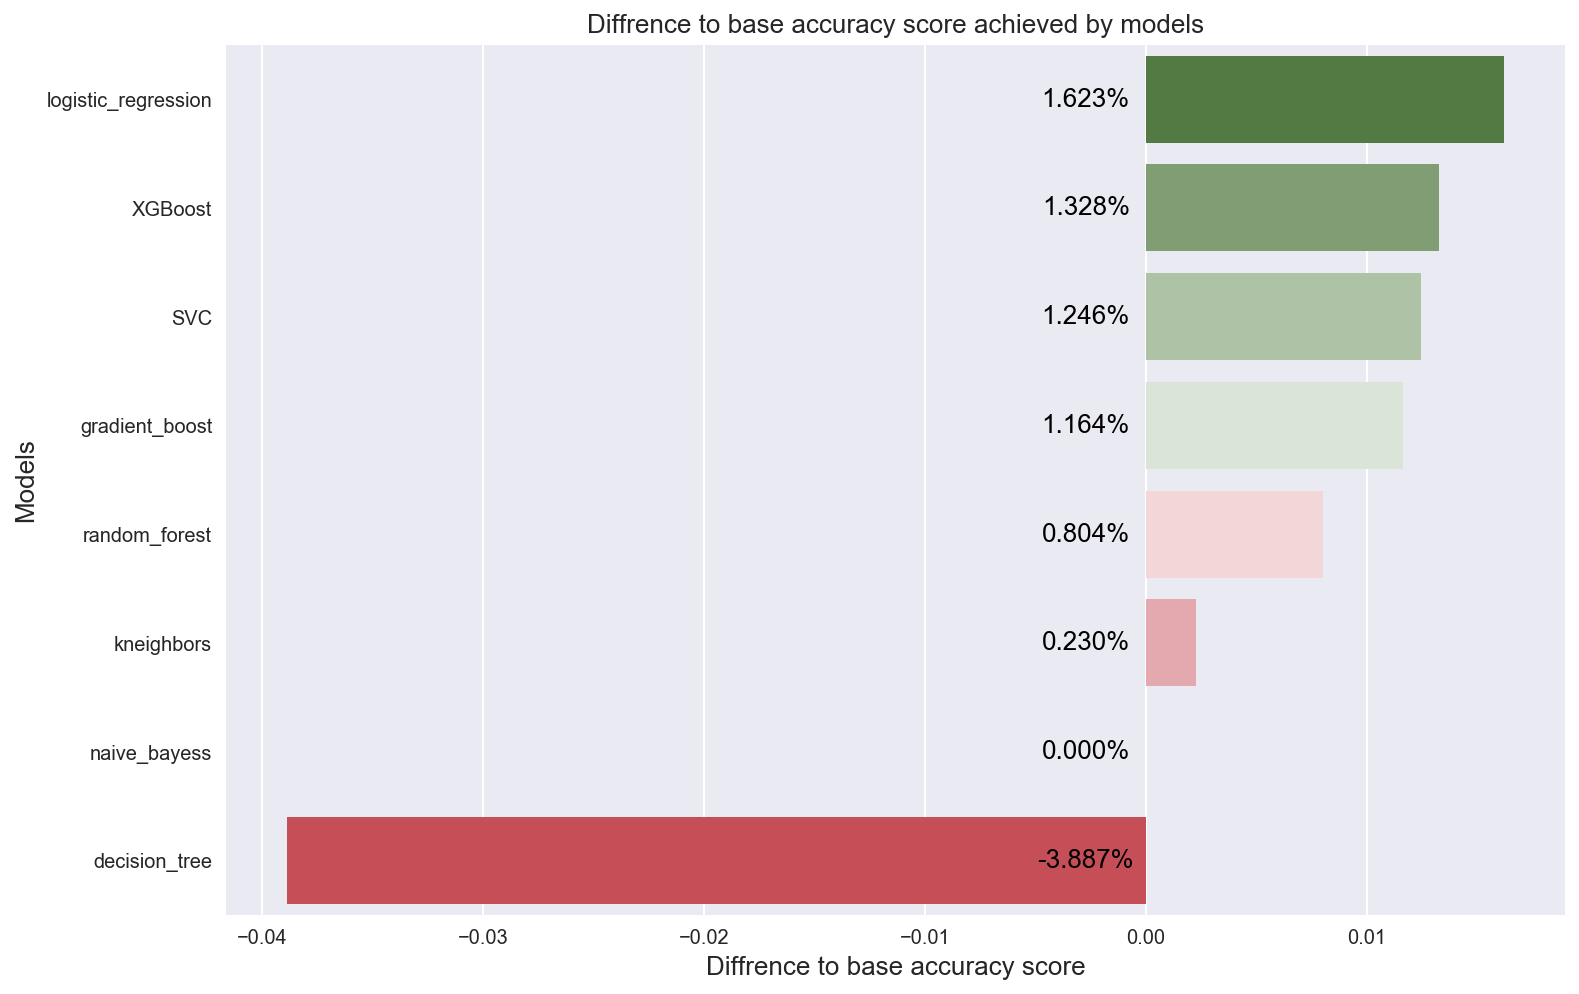

In [62]:
acc_diff = (models['accuracy'] - zero_score).to_frame()
palette = sns.diverging_palette(120, 10, sep=1, n=models['accuracy'].nunique(),center="light")
plt.figure(figsize=(12,8))
plot = sns.barplot(x="accuracy", y=acc_diff.index, data=acc_diff, palette=palette)
for p in plot.patches:
    plot.annotate(s='{:.3%}'.format(p.get_width()),xy=(0, p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(-30, 0), textcoords='offset points', color='black',
    fontsize=13)
plt.xlabel('Diffrence to base accuracy score', fontdict={'fontsize':13})
plt.ylabel('Models', fontdict={'fontsize':13})
plt.title('Diffrence to base accuracy score achieved by models', 
          fontdict={'fontsize':13})
plt.show()

The above chart shows the differences that individual models achieved in relation to this baseline score. Logistic regression was characterized by the best prediction.

However, the worst results should be emphasized: 
- Naive Bayess decided to assign a value of 0 to each customer. Although this makes sense in terms of probability, it is useless for a bank that wants to find customers more willing to accept an offer.
- The decision tree model, on the other hand, has significantly worse results than the other ones and on top of that also achieves a much worse accuracy than base score.

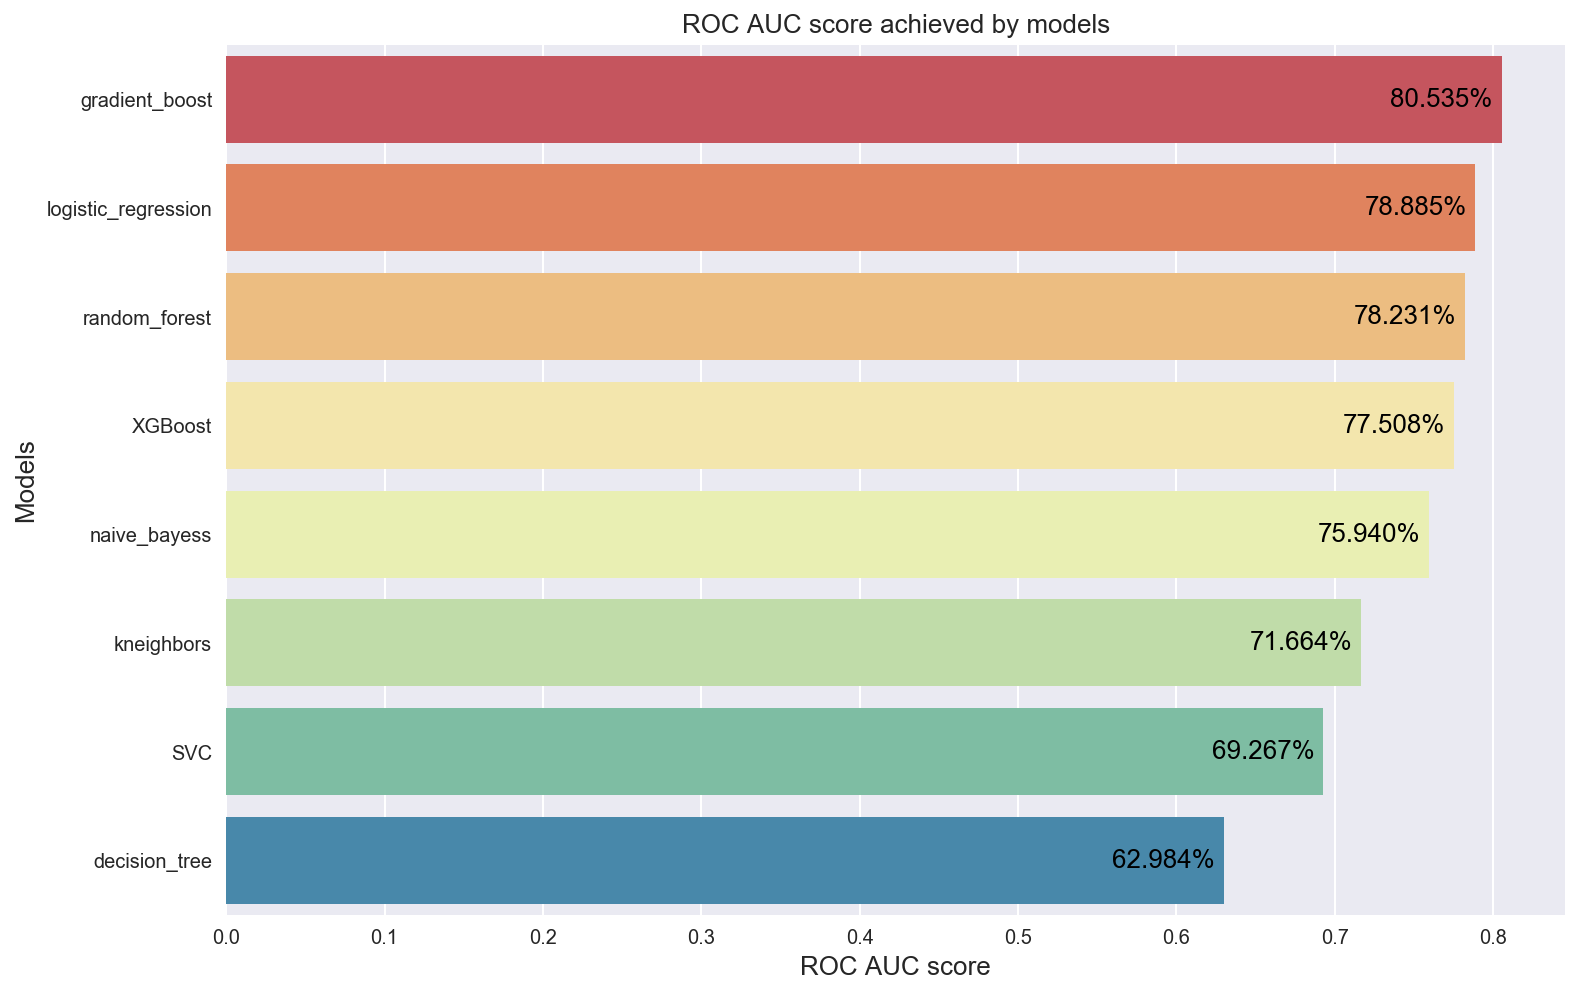

In [63]:
models.sort_values('roc_auc', ascending=False, inplace=True)
plt.figure(figsize=(12,8))
plot = sns.barplot(x="roc_auc", y=models.index, data=models, palette='Spectral')
for p in plot.patches:
    plot.annotate(s='{:.3%}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(-30, 0), textcoords='offset points', color='black',
    fontsize=13)
plt.xlabel('ROC AUC score', fontdict={'fontsize':13})
plt.ylabel('Models', fontdict={'fontsize':13})
plt.title('ROC AUC score achieved by models', fontdict={'fontsize':13})
plt.show()

For this analysis, the ROC AUC score is more important than the standard accuracy score. In this case, the best model is 'gradient boost classifier'. 

This is also confirmed by the analysis of confusion matrices (below).

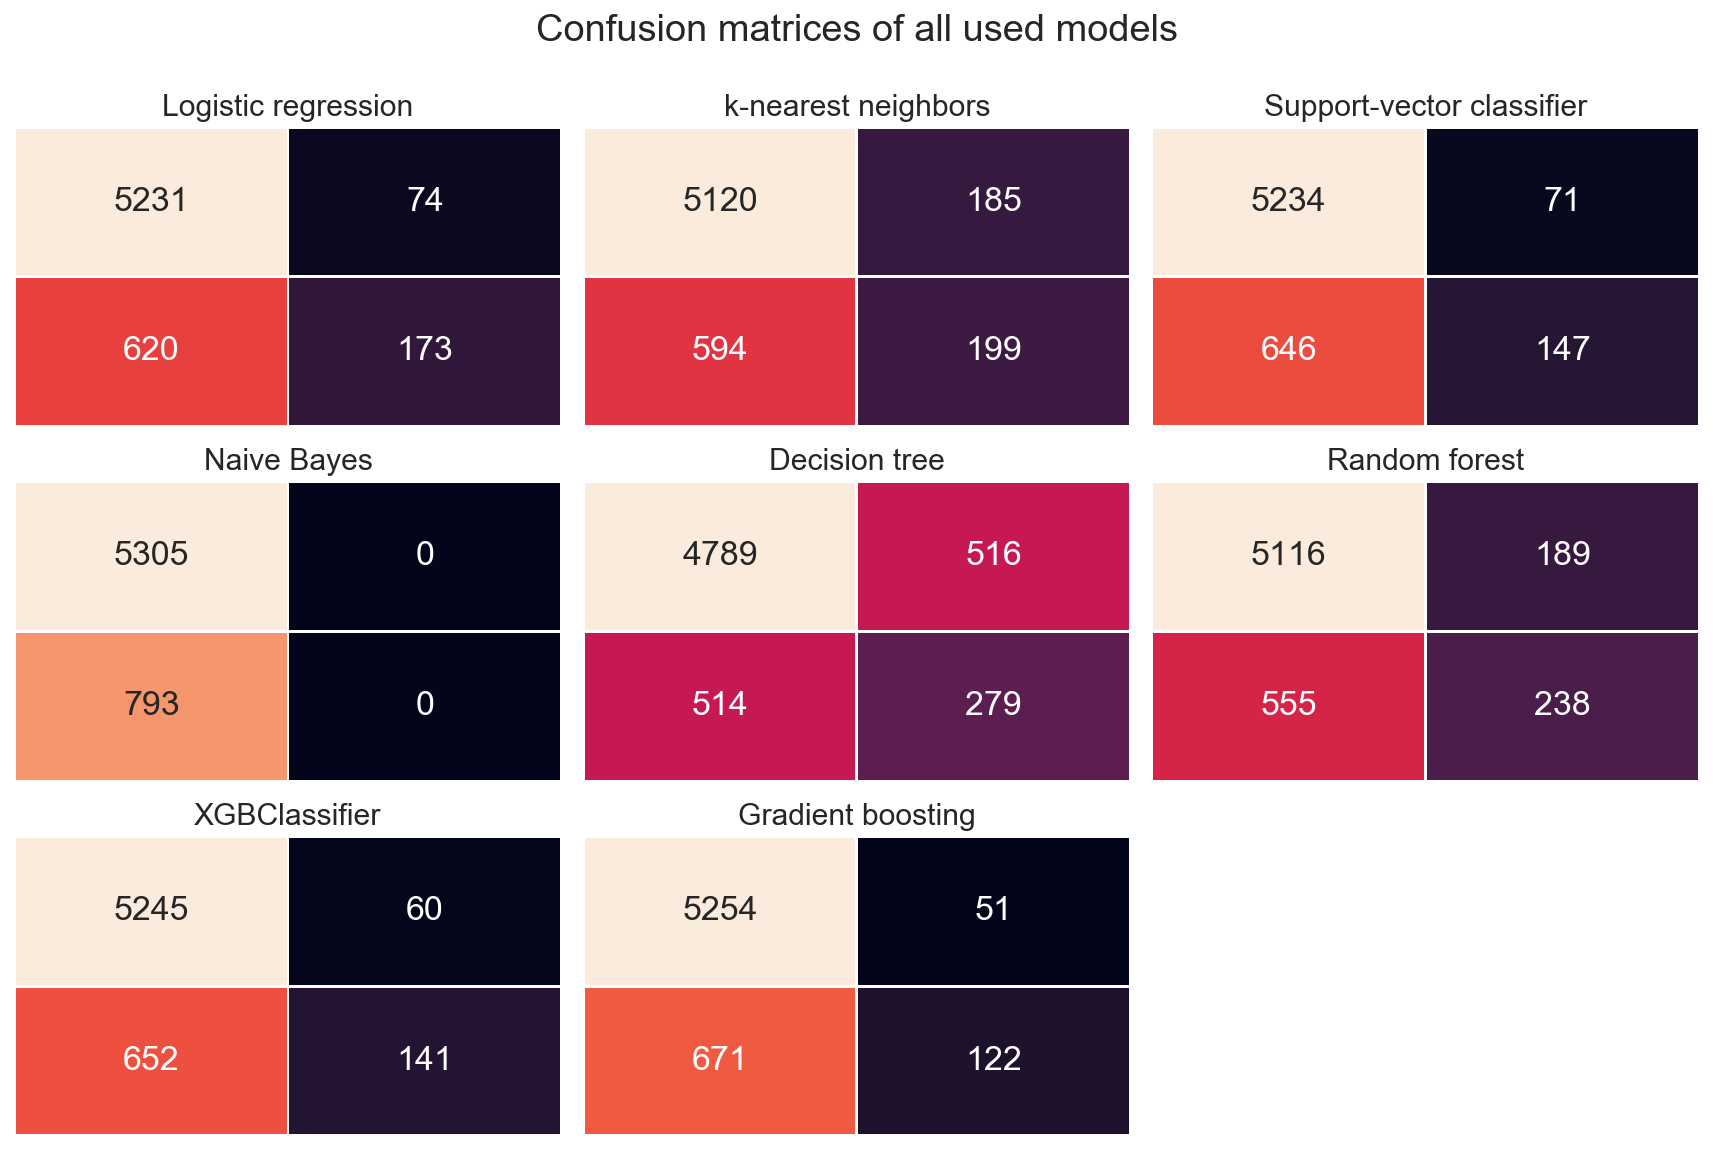

In [64]:
confusion_list = [confusion_matrix(y_test, y_pred_log), confusion_matrix(y_test, y_pred_kn),
                  confusion_matrix(y_test, y_pred_svc), confusion_matrix(y_test, y_pred_nb),
                  confusion_matrix(y_test, y_pred_tree), confusion_matrix(y_test, y_pred_rf),
                  confusion_matrix(y_test, y_pred_xgb), confusion_matrix(y_test, y_pred_gbc)]
model_list = ['Logistic regression', 'k-nearest neighbors', 'Support-vector classifier',
             'Naive Bayes', 'Decision tree', 'Random forest', 'XGBClassifier', 'Gradient boosting']

plt.figure(figsize=(12,10))
plt.suptitle('Confusion matrices of all used models', y=1.04, fontsize=19) 
subplot = 431
for matrix, name in zip(confusion_list, model_list):
    plt.subplot(subplot)
    plt.title(name,fontdict={'fontsize':15})
    sns.heatmap(matrix, annot=True, cbar=False, fmt="d", linewidths=1, vmin=50, vmax=1000,
               annot_kws={'fontsize':17}, xticklabels='', yticklabels='')
    subplot += 1
plt.tight_layout()
plt.show()

Confusion matrix (for binary classification) is a table with two rows and two columns that reports the number of false positives, false negatives, true positives, and true negatives predictions. This allows more detailed analysis than mere proportion of correct classifications (accuracy).

From the bank's perspective, this problem requires that the model should be focused on identifying customers who are willing to accept the offer presented by the bank - this means that the appropriate model must have a high number of true positives and the lowest possible number of false positive errors.

In the present case, it seems that the best model in these circumstances is the 'gradient boosting classifier', which only 51 made the mistake of classifying the client as willing to accept the bank's offer.

It is worth noting that in theory no such error was made by 'naive bayess classifier', but this model did not consider any customer to be potentially willing to accept the offer.

In [65]:
models.sort_values('precision', ascending=False)

,accuracy,roc_auc,f1,precision,recall
naive_bayess,0.869957,0.759401,0.000000,1.000000,0.000000
gradient_boost,0.881601,0.805352,0.252588,0.705202,0.153846
XGBoost,0.883240,0.775076,0.283702,0.701493,0.177806
logistic_regression,0.886192,0.788851,0.332692,0.700405,0.218159
SVC,0.882420,0.692670,0.290801,0.674312,0.185372
random_forest,0.877993,0.782309,0.390164,0.557377,0.300126
kneighbors,0.872253,0.716640,0.338148,0.518229,0.250946
decision_tree,0.831092,0.629843,0.351385,0.350943,0.351828


The above is also confirmed by the precision score value, i.e. high precision means that an algorithm returned substantially more relevant results than irrelevant ones. In this case 'gradient boosting classifier' also reached the highest value (excluding 'naive bayess').

To sum up the above conclusions, 'gradient boosting classifier'. should be considered as the best prediction model for this dataset.

Below is the predictive power of the model based on cumulative accuracy profile.

In [66]:
total_subsribed = y_test.sum()
total_records = y_test.shape[0]
subscription_rate = total_subsribed / total_records

cap_curve = pd.DataFrame(data=[y_test, y_proba_gbc[:,1]]).transpose()
cap_curve.columns = ['subscribed', 'gbc_p_hat']
cap_curve.sort_values('gbc_p_hat', ascending=False, inplace=True)
cap_curve.reset_index(inplace=True)

cap_curve['random'] = (cap_curve.index + 1) * subscription_rate
cap_curve['random_prc'] = cap_curve['random'] / total_subsribed

cap_curve['model'] = cap_curve['subscribed'].cumsum()
cap_curve['model_prc'] = cap_curve['model'] / total_subsribed

cap_curve['perfect_model'] = sorted(y_test, reverse=True)
cap_curve['perfect_model'] =  cap_curve['perfect_model'].cumsum()
cap_curve['perfect_model_prc'] = cap_curve['perfect_model'] / total_subsribed

cap_curve

,index,subscribed,gbc_p_hat,random,random_prc,model,model_prc,perfect_model,perfect_model_prc
0,1794,1.0,0.681944,0.130043,0.000164,1.0,0.001261,1,0.001261
1,1429,1.0,0.677264,0.260085,0.000328,2.0,0.002522,2,0.002522
2,2615,1.0,0.673467,0.390128,0.000492,3.0,0.003783,3,0.003783
3,3043,1.0,0.670888,0.520171,0.000656,4.0,0.005044,4,0.005044
4,3968,1.0,0.665603,0.650213,0.000820,5.0,0.006305,5,0.006305
...,...,...,...,...,...,...,...,...,...
6093,4134,0.0,0.059123,792.479829,0.999344,793.0,1.000000,793,1.000000
6094,2798,0.0,0.059123,792.609872,0.999508,793.0,1.000000,793,1.000000
6095,5867,0.0,0.059123,792.739915,0.999672,793.0,1.000000,793,1.000000
6096,4757,0.0,0.058185,792.869957,0.999836,793.0,1.000000,793,1.000000


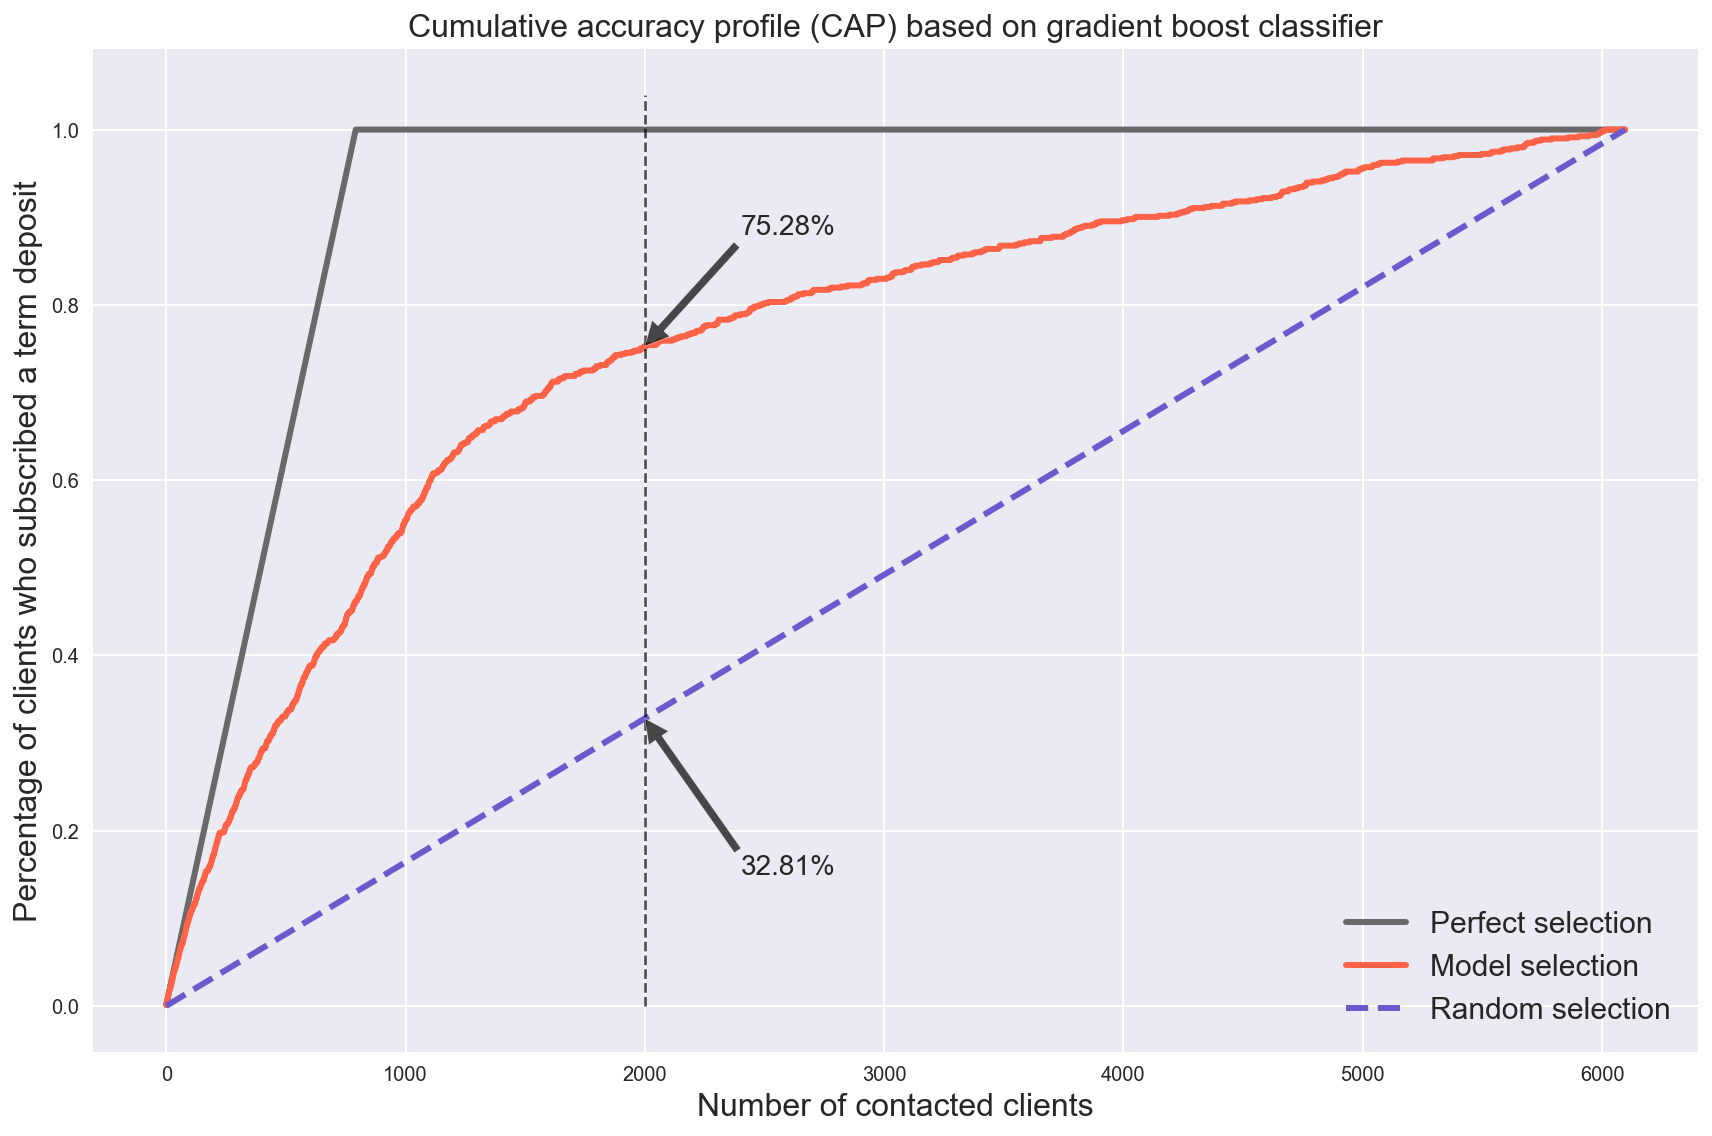

In [67]:
plt.figure(figsize=(12,8))
plt.plot(cap_curve['perfect_model_prc'], color='dimgrey', label='Perfect selection', lw=3)
plt.plot(cap_curve['model_prc'], color='tomato', label='Model selection', lw=3)
plt.plot(cap_curve['random_prc'], color='slateblue', label='Random selection', 
         lw=3, linestyle='--')

plt.plot([2000, 2000], [0,1.04], 'k--', lw=1.3, alpha=0.7)
plt.annotate(s='{0:.2%}'.format(cap_curve['model_prc'].loc[2000]), 
             xy=(2000, cap_curve['model_prc'].loc[2000]), size=14,
            xytext=(2400,0.88), arrowprops=dict(facecolor='black', alpha=0.7))

plt.annotate(s='{0:.2%}'.format(cap_curve['random_prc'].loc[2000]), 
             xy=(2000, cap_curve['random_prc'].loc[2000]), size=14,
            xytext=(2400,0.15), arrowprops=dict(facecolor='black', alpha=0.7))

plt.xlabel('Number of contacted clients', fontdict={'fontsize':16})
plt.ylabel('Percentage of clients who subscribed a term deposit', fontdict={'fontsize':16})
plt.title('Cumulative accuracy profile (CAP) based on gradient boost classifier',
          fontdict={'fontsize':16})
plt.legend(loc='lower right', prop={'size':15})
plt.tight_layout()
plt.show()

The CAP of a model represents the cumulative number of positive outcomes along the y-axis versus the corresponding cumulative number of a classifying parameter along the x-axis (source: Wikipedia).

In the present case, the bank wants to first contact the clients who were considered by the model to be the most willing to accept the offer. A perfect model that has not been mistaken once (marked in grey on the chart) after 793 first contacts would contact all customers willing to accept the bank's offer.

The dotted blue line symbolizes completely random selection of the order of contact with customers, without the help from any statistical or machine learning model.

The selected model, gradient boosting classifier, marked in orange, is not as good as the ideal model, but still better than random selection. For example, after contacting the first 2,000 customers at random, statistically 32.81% would agree to the bank's offer. However, choosing customers according to the selected model as much as 75.28% of the same number would accept the bank's offer.

In [68]:
cap_curve['model_prc'].loc[y_test.shape[0]/2]

0.8373266078184111

The CAP curve serves as a model assessment - to do this, it is necessary to set a predictive value of 50% of all customers contacted. For the selected model, this value is 83.73%. The value is assigned to the following brackets to analyse it:
1. Less than 60%: Rubbish Model
2. 60% — 70%: Poor Model
3. 70% — 80%: Good Model
4. 80% — 90%: Very Good Model
5. More than 90%: Too Good to be True

(source: https://towardsdatascience.com/machine-learning-classifier-evaluation-using-roc-and-cap-curves-7db60fe6b716)

According to these values, the chosen GBC model should be considered as very good.

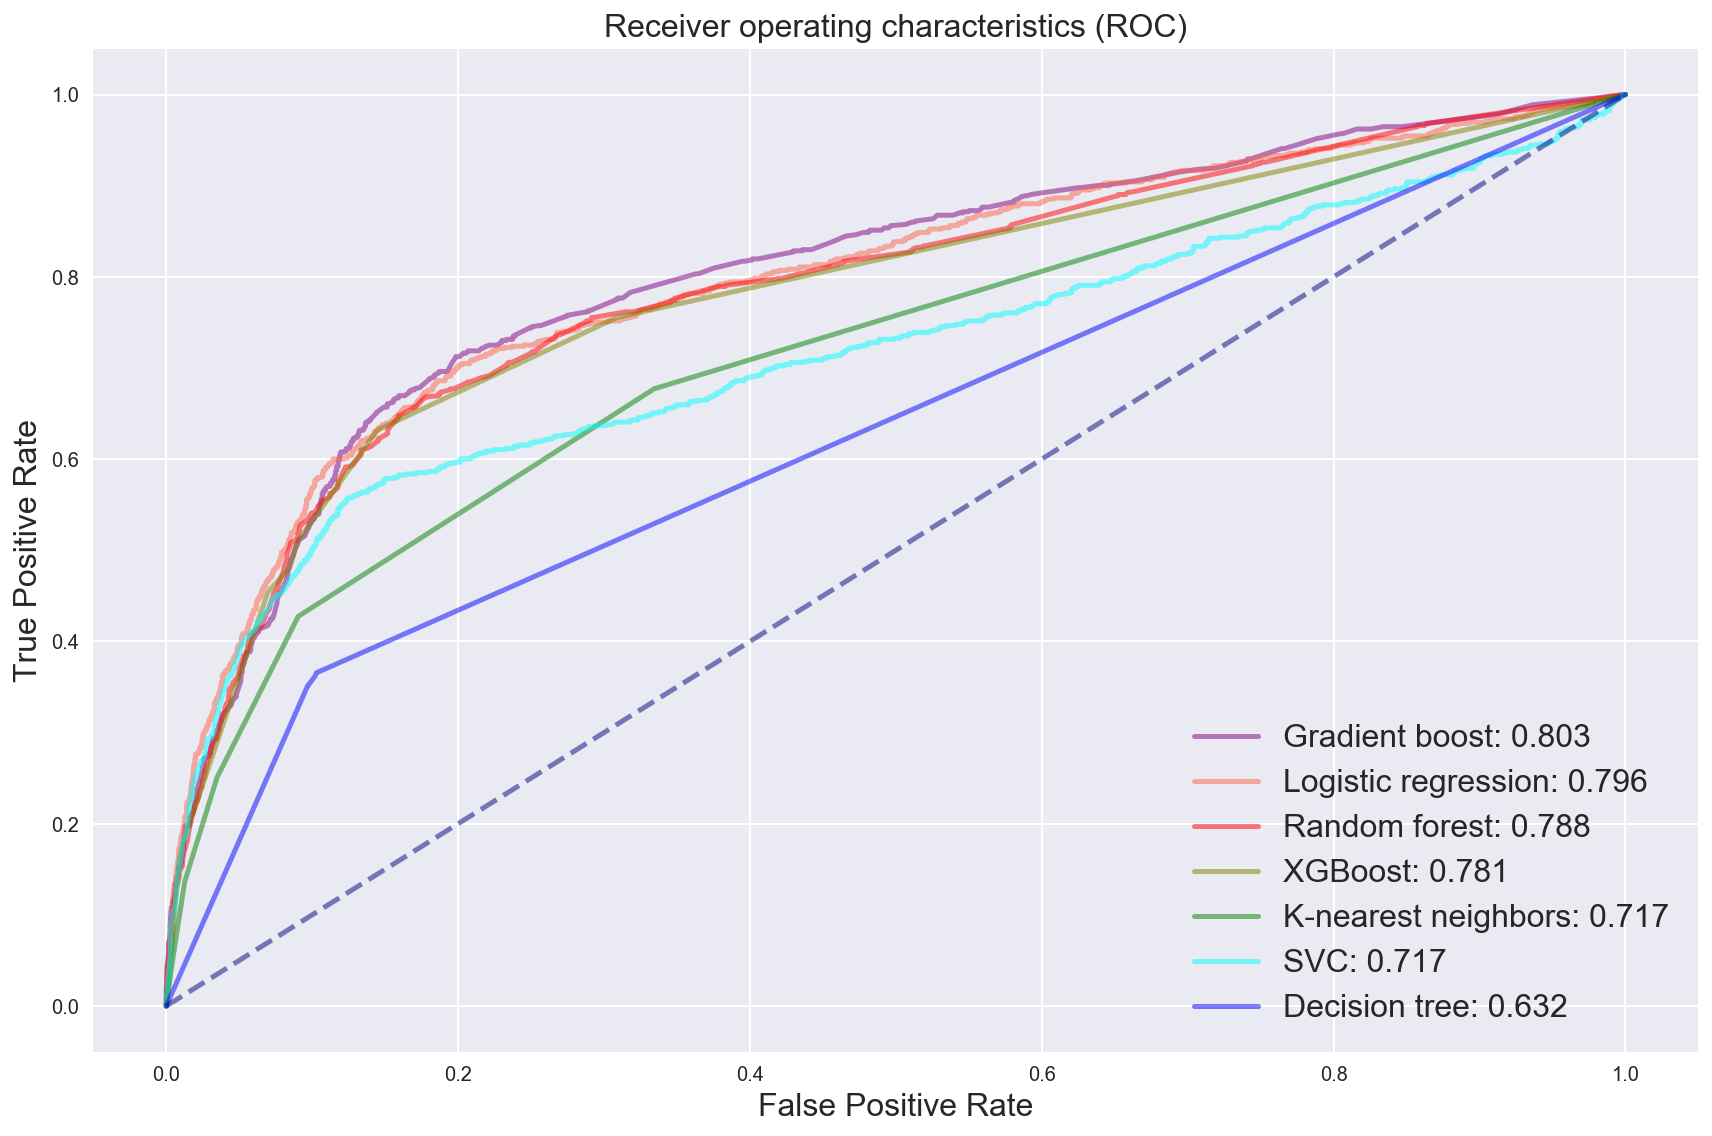

In [69]:
fpr_log, tpr_log, thresholds = roc_curve(y_test, y_proba_log[:,1])
fpr_kn, tpr_kn, thresholds = roc_curve(y_test, y_proba_kn[:,1])
fpr_tree, tpr_tree, thresholds = roc_curve(y_test, y_proba_tree[:,1])
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_proba_rf[:,1])
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_test, y_proba_xgb[:,1])
fpr_gbc, tpr_gbc, thresholds = roc_curve(y_test, y_proba_gbc[:,1])
fpr_svc, tpr_svc, thresholds = roc_curve(y_test, y_score_svc)

roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_kn = auc(fpr_kn, tpr_kn)
roc_auc_tree = auc(fpr_tree, tpr_tree)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_gbc = auc(fpr_gbc, tpr_gbc)
roc_auc_svc = auc(fpr_svc, tpr_svc)

plt.figure(figsize=(12,8))

plt.plot(fpr_gbc, tpr_gbc, c='purple', lw=2.5, 
         label='Gradient boost: {0:.3f}'.format(roc_auc_gbc), alpha=0.5)
plt.plot(fpr_log, tpr_log, c='tomato', lw=2.5, 
         label='Logistic regression: {0:.3f}'.format(roc_auc_log), alpha=0.5)
plt.plot(fpr_rf, tpr_rf, c='red', lw=2.5, 
         label='Random forest: {0:.3f}'.format(roc_auc_rf), alpha=0.5)
plt.plot(fpr_xgb, tpr_xgb, c='olive', lw=2.5, 
         label='XGBoost: {0:.3f}'.format(roc_auc_xgb), alpha=0.5)
plt.plot(fpr_kn, tpr_kn, c='green', lw=2.5, 
         label='K-nearest neighbors: {0:.3f}'.format(roc_auc_kn), alpha=0.5)
plt.plot(fpr_svc, tpr_svc, c='cyan', lw=2.5, 
         label='SVC: {0:.3f}'.format(roc_auc_svc), alpha=0.5)
plt.plot(fpr_tree, tpr_tree, c='blue', lw=2.5, 
         label='Decision tree: {0:.3f}'.format(roc_auc_tree), alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=2.5, linestyle='--', alpha=0.5)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristics (ROC)', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
plt.tight_layout()
plt.show()

A receiver operating characteristic curve (ROC curve) measure the performance of a Classification model. The True Positive Rate is plot against False Positive Rate for the probabilities of the classifier predictions. In this case it is very easy to check which model is doing the best (gradient boost) and which model is worst (decision tree).

In [70]:
log_selector = RFE(log_classifier, n_features_to_select=1)
log_selector.fit(X_train, y_train)

for feature, number in zip(log_selector.ranking_[:10], range(10)): #top 10 features
    print('{}:\t{}'.format(number+1, X.columns[feature-1]))

1:	education_illiterate
2:	job_management
3:	nr.employed
4:	emp.var.rate
5:	job_unemployed
6:	campaign
7:	previous_contact
8:	education_university.degree
9:	day_of_week
10:	age


For information purposes it may be interesting to check which attributes of customer data have been selected by the given models as significant and which have been not. Above, on the example of logistic regression, the top 10 most important features for this model is shown.

However, not every model selects the same features as relevant.

In [71]:
importance = {'decision_tree' : tree_classifier.feature_importances_,
              'random_forest' : rf_classifier.feature_importances_}
importance_df = pd.DataFrame(data=importance, index=df_cat.columns)
importance_df.sort_values('decision_tree', ascending=False).head()

,decision_tree,random_forest
age,0.186216,0.190821
nr.employed,0.158468,0.050939
euribor3m,0.120881,0.157505
campaign,0.087758,0.088899
job,0.073271,0.088722


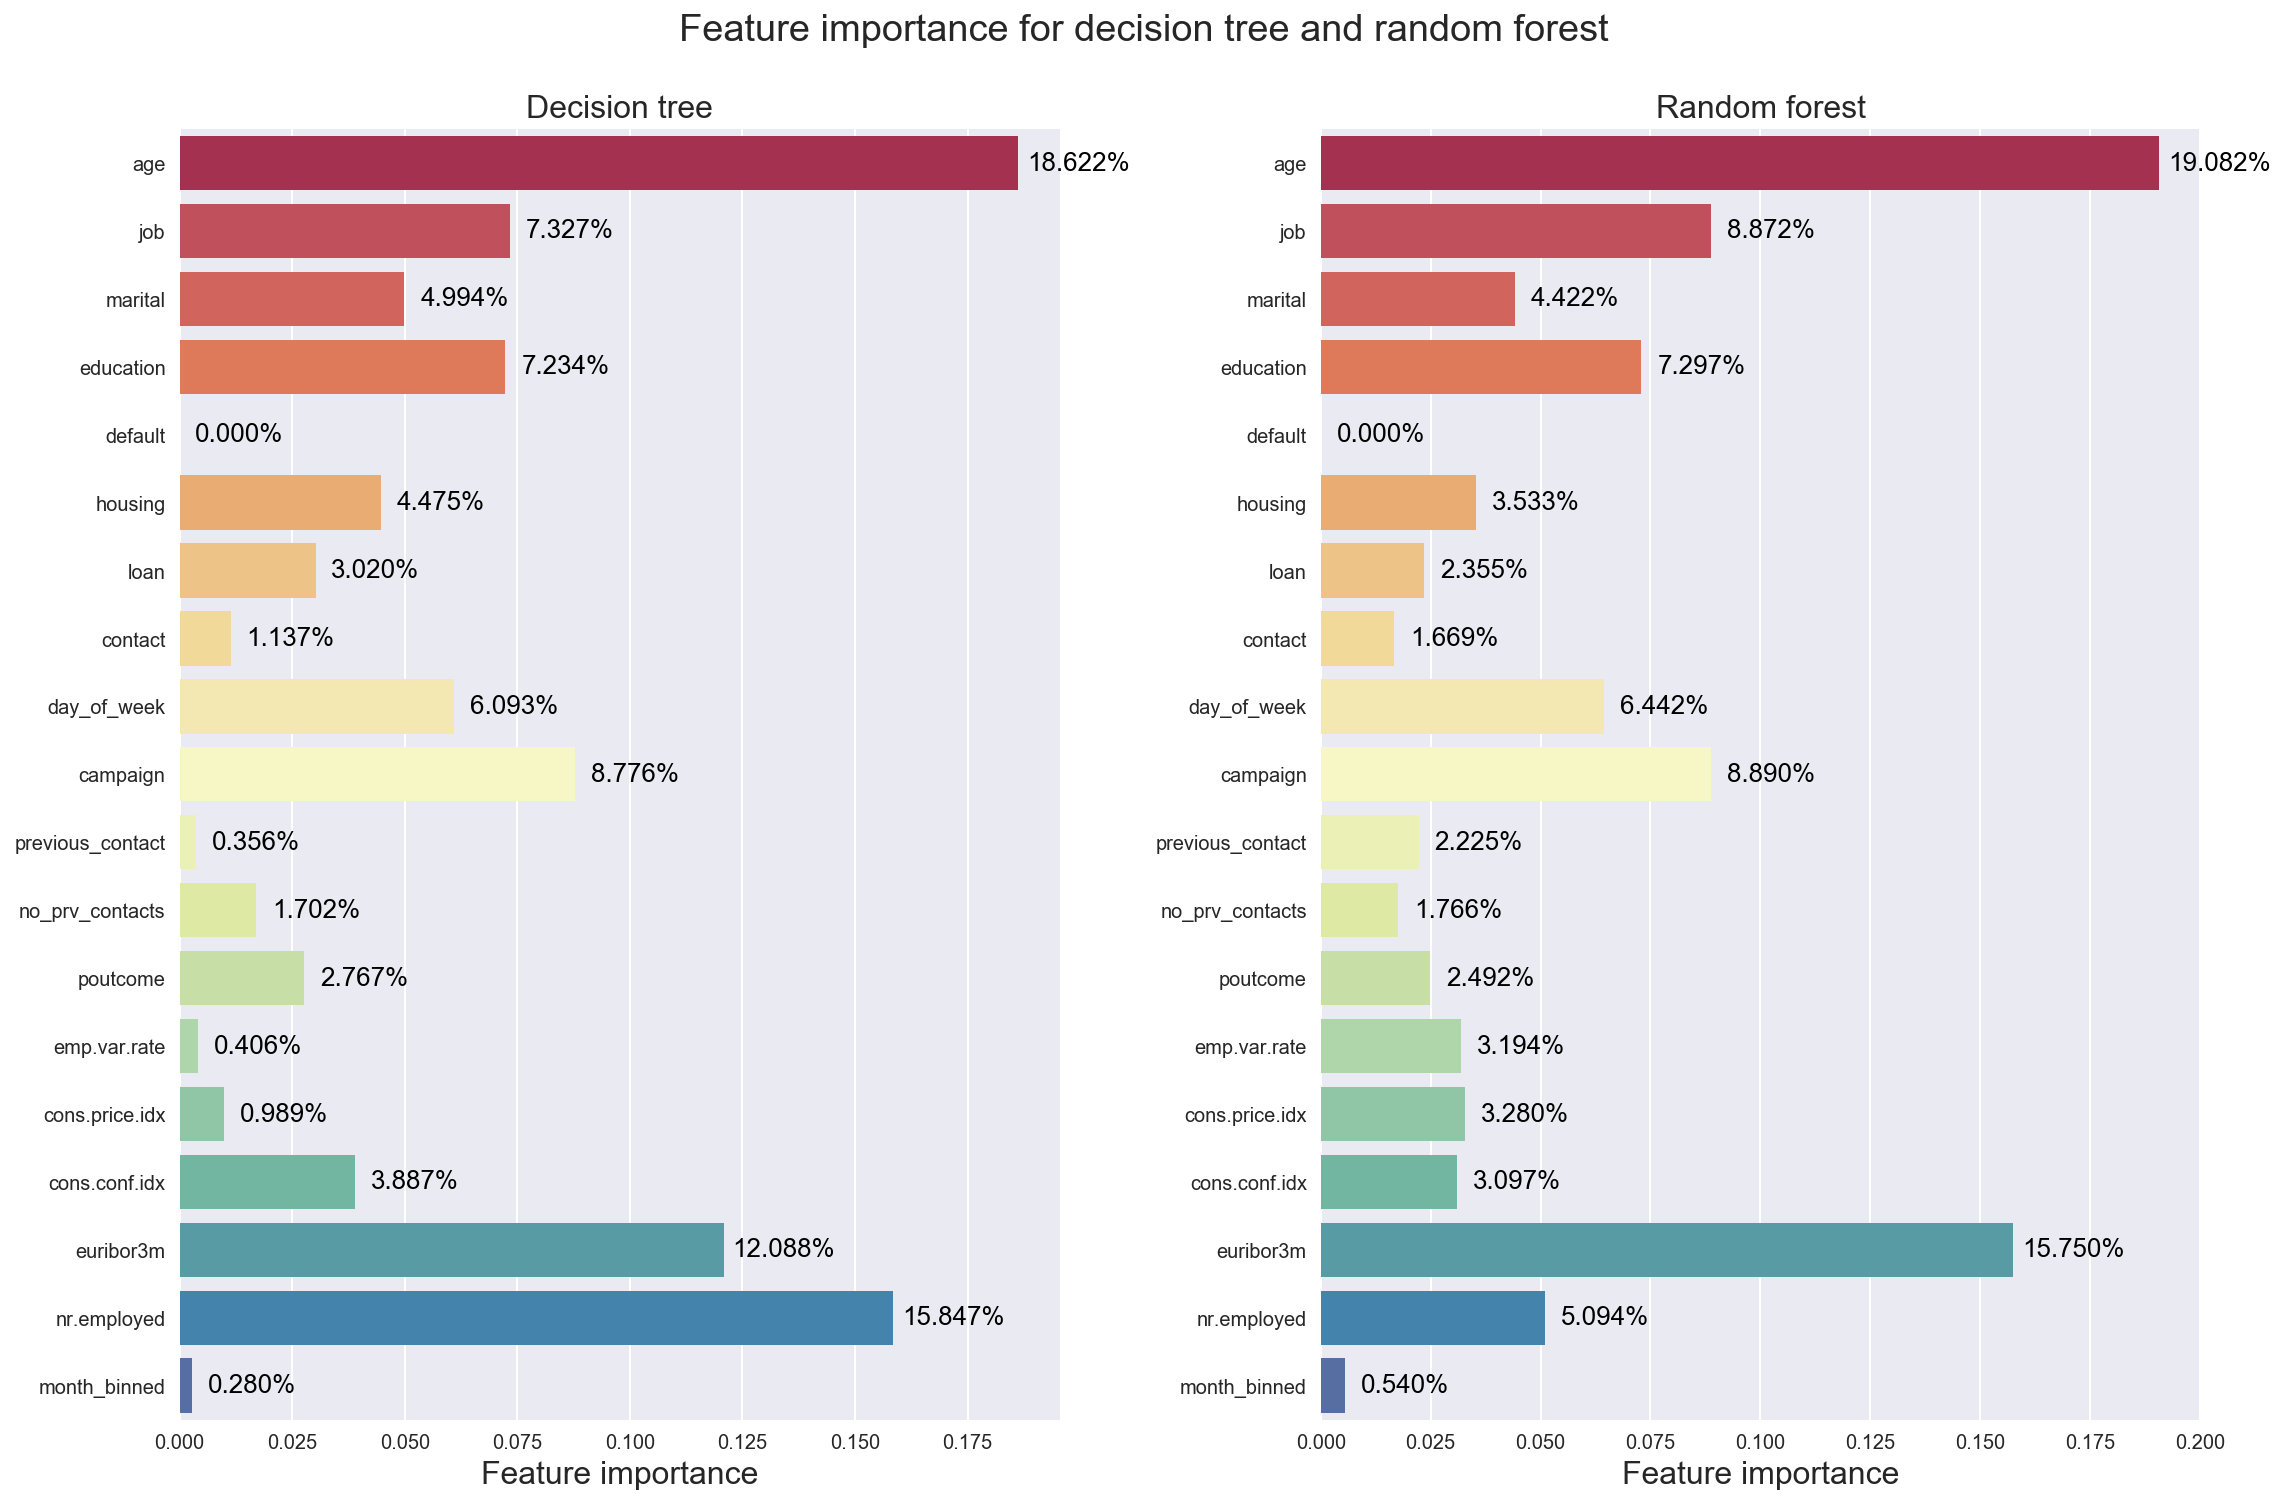

In [72]:
plt.figure(figsize=(16,10))
plt.suptitle('Feature importance for decision tree and random forest', y=1.04, fontsize=19) 
plt.subplot(121)
plot = sns.barplot(x='decision_tree', palette='Spectral',
                   y=importance_df.index, 
                   data=importance_df)
for p in plot.patches:
    plot.annotate(s='{:.3%}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(30, 0), textcoords='offset points', color='black',
    fontsize=13)
plt.title('Decision tree', fontsize=16)    
plt.xlabel('Feature importance', fontsize=16)
plt.subplot(122)
plot = sns.barplot(x='random_forest', palette='Spectral',
                   y=importance_df.index, 
                   data=importance_df)
for p in plot.patches:
    plot.annotate(s='{:.3%}'.format(p.get_width()),xy=(p.get_width(), p.get_y() + p.get_height()/2),
    ha='center', va='center', xytext=(30, 0), textcoords='offset points', color='black',
    fontsize=13)
plt.title('Random forest', fontsize=16)       
plt.xlabel('Feature importance', fontsize=16)
plt.tight_layout()
plt.show()

Above are the significance values that were assigned by the decision tree and random forest models. Although both models are similar to each other in terms of classification, there are differences between them - for example, they attach different significance to the value 'euribor3m'.

Although the predictive model has already been chosen, at the end of this analysis it is worth mentioning the possible further tuning of the model. The next step could be a more extensive search for the best parameters for the GBC model. Another idea, which will briefly be presented below, is to choose a different threshold value that determines which value (0 or 1) of a given prediction will be assigned to.

In [73]:
y_scores = cross_val_predict(gbc_classifier, X_train, y_train, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

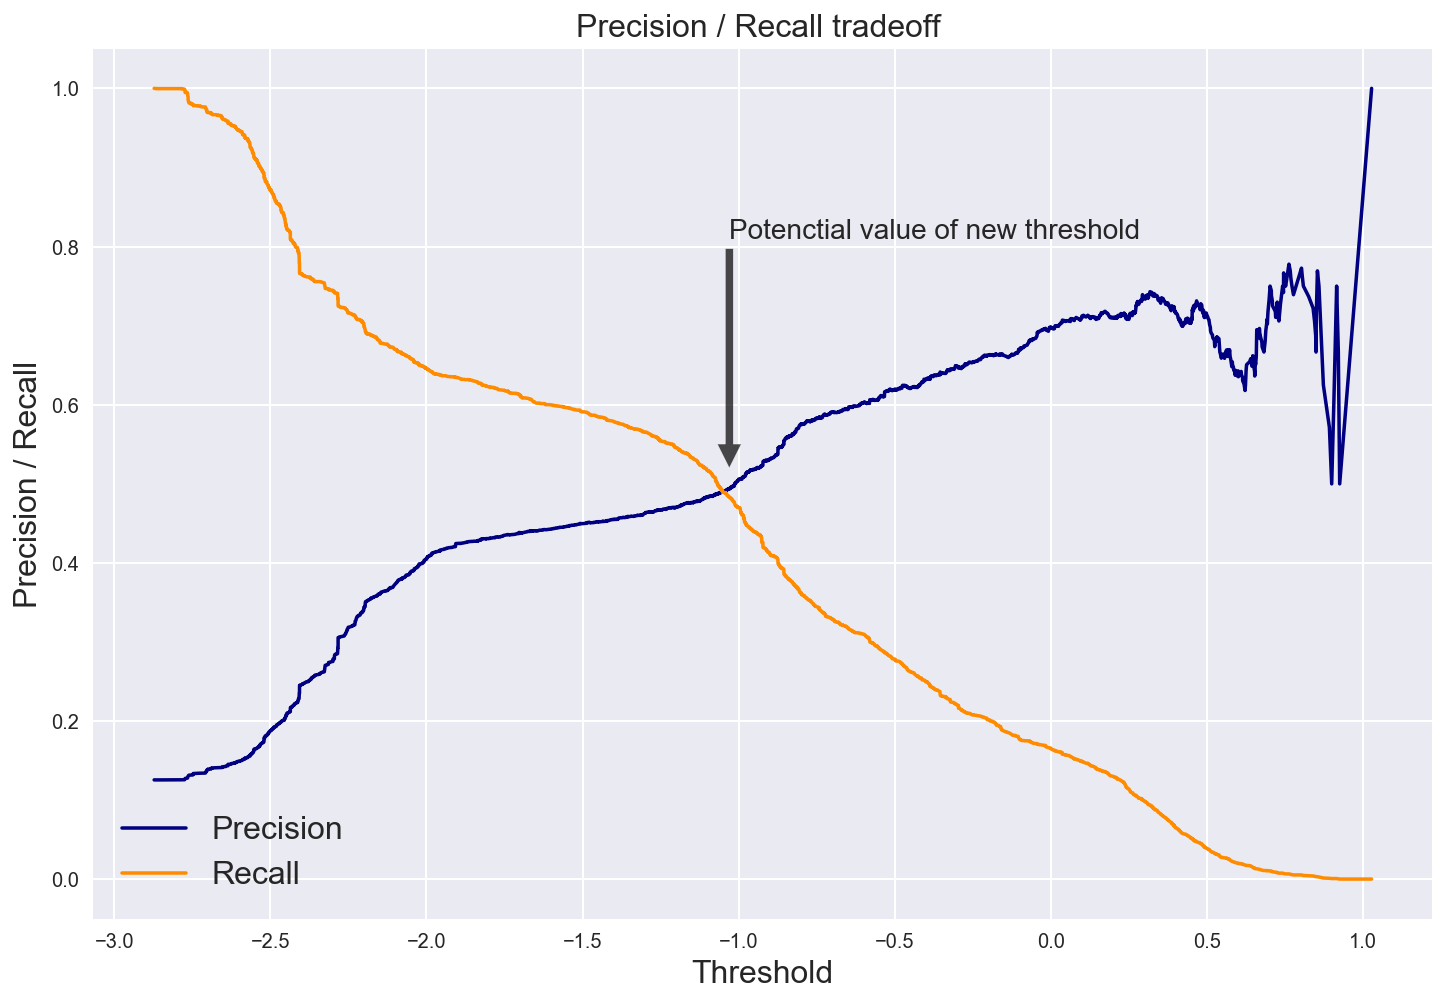

In [74]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, precisions[:-1], label='Precision', color='navy')
plt.plot(thresholds, recalls[:-1], label='Recall', color='darkorange')
plt.annotate(s='Potenctial value of new threshold', xy=(-1.03,0.52), size=14,
            xytext=(-1.03,0.81), arrowprops=dict(facecolor='black', alpha=0.7))
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Precision / Recall', fontsize=16)
plt.title('Precision / Recall tradeoff ', fontsize=16)
plt.legend(loc='best', fontsize=16)
plt.show()

Further testing of the threshold on which the classification value is based may give better predictive results. One suggestion is to set the threshold to a value at which precision and recall are equated. This will significantly increase the F1 score. In the event that the bank wants more precision in identifying customers more willing to accept their offer, it can increase the threshold in such a way as to increase the precision score at the expense of recall score.

In [75]:
new_y_train = (y_scores > -1.1)
print('F1: {}\nPrecision: {}\nRecall: {}'.format(f1_score(y_train, new_y_train), 
    precision_score(y_train, new_y_train), recall_score(y_train, new_y_train)))

F1: 0.49921210211156636
Precision: 0.48292682926829267
Recall: 0.5166340508806262


# Thank you very much! :)